# EDA

## 1. Load cleaned data

In [1]:
# Standard imports
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar, Generic
import time
import re

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Third party imports
from geopy.exc import  GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim
from haversine import haversine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager


In [2]:
data_path_manager = DataPathCleaningManager(data_timeplace)

df_olx = data_path_manager.load_df(domain="olx", is_cleaned=True)
df_otodom = data_path_manager.load_df(domain="otodom", is_cleaned=True)

### 1.1 OLX

In [3]:
df_olx

,link,title,price,summary_description,ownership,floor_level,is_furnished,building_type,square_meters,number_of_rooms,rent,voivodeship,city,street
0,https://www.olx.pl/d/oferta/kawalerka-tychy-os...,Kawalerka Tychy oś M,1500.0,OpisWynajmę kawalerkę na ul Moniuszki 1/16 .na...,private,3,False,apartment_building,26,1,400.0,Śląskie,Zawada,Moniuszki 1/16


In [4]:
df_olx.columns

Index(['link', 'title', 'price', 'summary_description', 'ownership',
       'floor_level', 'is_furnished', 'building_type', 'square_meters',
       'number_of_rooms', 'rent', 'voivodeship', 'city', 'street'],
      dtype='object')

### 1.2 otodom

In [5]:
df_otodom.sample(5)

listing  \
                                                   link   
182   https://www.otodom.pl/pl/oferta/mieszkanie-54-...   
834   https://www.otodom.pl/pl/oferta/jednoosobowy-p...   
205   https://www.otodom.pl/pl/oferta/maly-rynek-sto...   
1013  https://www.otodom.pl/pl/oferta/mieszkanie-2-p...   
41    https://www.otodom.pl/pl/oferta/wynajme-mieszk...   

                                                         \
                                                  title   
182   mieszkanie 54 m2 Koszutka - Nowe os. ul. Słone...   
834           Jednoosobowy pokój w Centrum, ul. Opolska   
205               Mały Rynek/Stojałowskiego bez czynszu   
1013          Mieszkanie 2 pokojowe KATOWICE Pułaskiego   
41        wynajmę mieszkanie w Jaworznie, centrum, 34m2   

                                                                        \
                                    summary_description remote_service   
182   Do wynajęcia całkowicie nowe mieszkanie na now...           <NA>   
834   Mieszkanie znajduje się na 2 piętrze w kamieni...           <NA>   
205   Nowe mieszkanie w centrum Jaworzna okolice Mał...           <NA>   
1013  FUNDUSZ MIESZKAŃ NA WYNAJEM    oferuje do wyna...           <NA>   
41    Mieszkanie na wynajem w Jaworznie. Ul. Urzędni...    unspecified   

     pricing                            \
       price   rent total_rent deposit   
182   3000.0  650.0     3650.0  6000.0   
834    790.0    1.0      791.0     NaN   
205   1800.0    1.0     1801.0  3000.0   
1013  2728.0    NaN     2728.0     NaN   
41    1500.0  500.0     2000.0  3000.0   

                                               location  \
                                       complete_address   
182       ul. Słoneczna 20, Koszutka, Katowice, śląskie   
834         ul. Opolska, Śródmieście, Katowice, śląskie   
205    ul. Obrońców Poczty Gdańskiej, Jaworzno, śląskie   
1013  ul. gen. Kazimierza Pułaskiego 27, Osiedle Pad...   
41                    ul. Urzędnicza, Jaworzno, śląskie   

                                         ... building_material              \
                                 street  ...          silicate large_panel   
182                    ul. Słoneczna 20  ...             False       False   
834                         ul. Opolska  ...             False       False   
205       ul. Obrońców Poczty Gdańskiej  ...             False       False   
1013  ul. gen. Kazimierza Pułaskiego 27  ...             False       False   
41                       ul. Urzędnicza  ...             False        True   

                         additional_information                          \
     reinforced_concrete         no_information duplex air_conditioning   
182                 True                   True  False            False   
834                False                   True  False            False   
205                False                  False  False            False   
1013               False                   True  False            False   
41                 False                  False  False            False   

                                                              
     separate_kitchen basement utility_room non_smokers_only  
182             False    False        False            False  
834             False    False        False            False  
205              True    False        False             True  
1013            False    False        False            False  
41              False     True        False            False  

[5 rows x 73 columns]

In [6]:
df_otodom.columns

MultiIndex([(               'listing',                           'link'),
            (               'listing',                          'title'),
            (               'listing',            'summary_description'),
            (               'listing',                 'remote_service'),
            (               'pricing',                          'price'),
            (               'pricing',                           'rent'),
            (               'pricing',                     'total_rent'),
            (               'pricing',                        'deposit'),
            (              'location',               'complete_address'),
            (              'location',                         'street'),
            (              'location',                           'city'),
            (              'location',                    'voivodeship'),
            (                  'size',                  'square_meters'),
            (                  'size',

### 1.3 Combined

In [7]:
def combine_olx_otodom(df_olx: pd.DataFrame = df_olx, df_otodom: pd.DataFrame = df_otodom):

    # Step 1: Create a mapping
    column_mapping = {
        'link': ('listing', 'link'),
        'title': ('listing', 'title'),
        'price': ('pricing', 'price'),
        'rent': ('pricing', 'rent'),
        'summary_description': ('listing', 'summary_description'),
        'ownership': ('legal_and_availability', 'ownership'),
        'floor_level': ('size', 'floor'),
        'is_furnished': ('equipment', 'furniture'),
        'building_type': ('type_and_year', 'building_type'),
        'square_meters': ('size', 'square_meters'),
        'number_of_rooms': ('size', 'number_of_rooms'),
        'rent': ('pricing', 'rent'),
        'voivodeship': ('location', 'voivodeship'),
        'city': ('location', 'city'),
        'street': ('location', 'street')
    }

    # Step 2: Modify df_olx to have a MultiIndex
    df_olx.columns = pd.MultiIndex.from_tuples([column_mapping[col] if col in column_mapping else (col, '') for col in df_olx.columns])

    # Step 3: Fill missing columns in df_olx
    # Identify missing columns
    missing_columns = set(df_otodom.columns) - set(df_olx.columns)

    # Fill missing columns with NaN or False
    for col in missing_columns:
        if col in [('equipment', 'furniture'),]:  # Add other boolean columns if any
            df_olx[col] = False
        else:
            df_olx[col] = np.nan

    # Reorder df_olx columns to match df_otodom
    df_olx = df_olx.reindex(columns=df_otodom.columns)

    # Add total_rent column
    df_olx[('pricing', 'total_rent')] = df_olx[('pricing', 'price')].add(df_olx[('pricing', 'rent')], fill_value=0)

    # Create complete_address column
    df_olx[('location', 'complete_address')] = df_olx.apply(
    lambda row: ', '.join(
        filter(None, [row[('location', 'street')], row[('location', 'city')], row[('location', 'voivodeship')]])
    ),
    axis=1
)
    pd.set_option('display.max_rows', None)
    df_olx.iloc[0]

    # Fill NaNs
    # Replacing NaN with False
    columns_to_fill_false = [
        ('size', 'attic'),
        ('amenities', 'elevator'),
        ('amenities', 'parking_space'),
        ('equipment', 'no_information'),
        ('equipment', 'stove'),
        ('equipment', 'fridge'),
        ('equipment', 'oven'),
        ('equipment', 'washing_machine'),
        ('equipment', 'TV'),
        ('equipment', 'dishwasher'),
        ('media_types', 'internet'),
        ('media_types', 'telephone'),
        ('media_types', 'cable_TV'),
        ('heating', 'electric'),
        ('heating', 'gas'),
        ('heating', 'other'),
        ('heating', 'boiler_room'),
        ('heating', 'district'),
        ('heating', 'tile_stove'),
        ('security', 'intercom_or_video_intercom'),
        ('security', 'anti_burglary_doors_or_windows'),
        ('security', 'monitoring_or_security'),
        ('security', 'anti_burglary_roller_blinds'),
        ('security', 'alarm_system'),
        ('security', 'enclosed_area'),
        ('windows', 'aluminum'),
        ('windows', 'wooden'),
        ('windows', 'plastic'),
        ('building_material', 'concrete'),
        ('building_material', 'aerated_concrete'),
        ('building_material', 'brick'),
        ('building_material', 'wood'),
        ('building_material', 'other'),
        ('building_material', 'lightweight_aggregate'),
        ('building_material', 'hollow_brick'),
        ('building_material', 'silicate'),
        ('building_material', 'large_panel'),
        ('building_material', 'reinforced_concrete'),
        ('additional_information', 'duplex'),
        ('additional_information', 'air_conditioning'),
        ('additional_information', 'separate_kitchen'),
        ('additional_information', 'basement'),
        ('additional_information', 'utility_room'),
        ('additional_information', 'non_smokers_only'),
    ] 
    for col in columns_to_fill_false:
        df_olx[col] = df_olx[col].fillna(False)

    # Replacing NaN with True
    columns_to_fill_true = [
        ('media_types', 'no_information'),
        ('heating', 'no_information'),
        ('security', 'no_information'),
        ('windows', 'no_information'),
        ('building_material', 'no_information'),
        ('additional_information', 'no_information'),
    ]

    for col in columns_to_fill_true:
        df_olx[col] = df_olx[col].fillna(True)

    # Step 5: Set the same dtypes for df_olx as in df_otodom
    for column in df_otodom.columns:
        if column in df_olx.columns:
            df_olx[column] = df_olx[column].astype(df_otodom[column].dtype)


    # Step 6: Append df_olx to df_otodom
    combined_df = pd.concat([df_otodom, df_olx], ignore_index=True)

    # Step 7: Add deposit_ratio column
    combined_df.loc[:, ("pricing", "deposit_ratio")] = np.where(
        combined_df["pricing"]["total_rent"] != 0,
        (combined_df["pricing"]["deposit"] / combined_df["pricing"]["total_rent"]).round(2),
        np.nan  # or 0, depending on your preference for default value
    )

    # Step 8: Add total price per square meter column
    combined_df.loc[:, ("pricing", "total_rent_sqm")] = (combined_df['pricing']['total_rent'] / combined_df['size']['square_meters']).replace([np.inf, -np.inf], np.nan)

    # Step 9: Reorder columns

    columns = combined_df.columns.tolist()

    new_and_old_columns = [
        (8, columns.index(("pricing", "deposit_ratio"))),
        (7, columns.index(("pricing", "total_rent_sqm"))),
    ]

    for new, old in new_and_old_columns:
        columns.insert(new, columns.pop(old))

    combined_df = combined_df[columns]

    return combined_df

combined_df = combine_olx_otodom(df_olx, df_otodom)

combined_df.tail()

listing  \
                                                   link   
1101  https://www.otodom.pl/pl/oferta/katowice-ligot...   
1102  https://www.otodom.pl/pl/oferta/katowice-centr...   
1103  https://www.otodom.pl/pl/oferta/kawalerka-bryn...   
1104  https://www.otodom.pl/pl/oferta/wynajme-mieszk...   
1105  https://www.olx.pl/d/oferta/kawalerka-tychy-os...   

                                                    \
                                             title   
1101  Katowice Ligota Koszalińska pokój blisko Śum   
1102       Katowice centrum 2 pokoje dla studentów   
1103                              Kawalerka Brynów   
1104        Wynajmę Mieszkanie / Pogoń / Sosnowiec   
1105                          Kawalerka Tychy oś M   

                                                                        \
                                    summary_description remote_service   
1101  Wynajem pokoju w bardzo dobrej lokalizacji. Ni...           <NA>   
1102  OFERTA POLECANA! Oferujemy do wynajęcia przytu...   virtual_tour   
1103  Kawalerka Katowice Brynów bardzo spokojne miej...           <NA>   
1104  Wynajmę mieszkanie 56 m2 , dwa pokoje , kuchni...           <NA>   
1105  OpisWynajmę kawalerkę na ul Moniuszki 1/16 .na...           <NA>   

     pricing                                                         ...  \
       price   rent total_rent total_rent_sqm deposit deposit_ratio  ...   
1101   800.0    NaN      800.0      61.538462  1200.0          1.50  ...   
1102  1499.0    NaN     1499.0      39.447368  3000.0          2.00  ...   
1103  1300.0    NaN     1300.0      38.235294  2600.0          2.00  ...   
1104   700.0    NaN      700.0           12.5  2000.0          2.86  ...   
1105  1500.0  400.0     1900.0      73.076923     NaN           NaN  ...   

     building_material                                 additional_information  \
              silicate large_panel reinforced_concrete         no_information   
1101             False       False               False                  False   
1102             False       False               False                  False   
1103             False       False               False                  False   
1104             False       False               False                  False   
1105             False       False               False                   True   

                                                                     \
     duplex air_conditioning separate_kitchen basement utility_room   
1101  False            False             True    False        False   
1102  False            False             True     True        False   
1103  False            False             True     True        False   
1104  False            False            False     True        False   
1105  False            False            False    False        False   

                       
     non_smokers_only  
1101            False  
1102            False  
1103            False  
1104            False  
1105            False  

[5 rows x 75 columns]

In [8]:
pd.reset_option('display.max_rows')

In [9]:
combined_df.dtypes.to_dict()

{('listing', 'link'): string[python],
 ('listing', 'title'): string[python],
 ('listing', 'summary_description'): string[python],
 ('listing', 'remote_service'): string[python],
 ('pricing', 'price'): dtype('float64'),
 ('pricing', 'rent'): dtype('float64'),
 ('pricing', 'total_rent'): dtype('float64'),
 ('pricing', 'total_rent_sqm'): Float64Dtype(),
 ('pricing', 'deposit'): dtype('float64'),
 ('pricing', 'deposit_ratio'): dtype('float64'),
 ('location', 'complete_address'): string[python],
 ('location', 'street'): string[python],
 ('location', 'city'): string[python],
 ('location', 'voivodeship'): string[python],
 ('size', 'square_meters'): Int64Dtype(),
 ('size', 'number_of_rooms'): Int64Dtype(),
 ('size', 'floor'): Int64Dtype(),
 ('size', 'attic'): dtype('bool'),
 ('size', 'building_floors'): Int64Dtype(),
 ('legal_and_availability', 'available_from'): string[python],
 ('legal_and_availability', 'completion'): string[python],
 ('legal_and_availability', 'ownership'): string[python],

In [10]:
data_path_manager.save_df(combined_df, domain="combined")

In [11]:
combined_df = data_path_manager._load_cleaned_df(domain="combined")
combined_df.sample(5)

listing  \
                                                   link   
854   https://www.otodom.pl/pl/oferta/komfortowe-mie...   
816   https://www.otodom.pl/pl/oferta/przestronne-i-...   
418   https://www.otodom.pl/pl/oferta/mieszkanie-dwu...   
1061  https://www.otodom.pl/pl/oferta/mieszkanie-36-...   
665   https://www.otodom.pl/pl/oferta/do-wynajecia-k...   

                                                         \
                                                  title   
854              Komfortowe mieszkanie dla 2 studentów!   
816    Przestronne i ustawne 2 pokoje! 3 min. do Parku!   
418   Mieszkanie dwupokojowe 38m2 - nowy blok Sosnowiec   
1061                    Mieszkanie, 36,25 m², Sosnowiec   
665   Do wynajęcia KAWALERKA -- 19,36 m2 Świętochłowice   

                                                                        \
                                    summary_description remote_service   
854   Oferujemy Państwu do wynajęcia komfortowe mies...           <NA>   
816   Do wynajęcia od listopada wyjątkowe mieszkanie...           <NA>   
418   Mamy do zaoferowania komfortowe mieszkanie do ...    unspecified   
1061  Oferuję mieszkanie do wynajęcia od zaraz!!!!Mi...           <NA>   
665   Do wynajęcia kawalerka Świętochłowice ul. Kato...           <NA>   

     pricing                                                       ...  \
       price rent total_rent total_rent_sqm deposit deposit_ratio  ...   
854   1800.0  NaN     1800.0      48.648649  1800.0          1.00  ...   
816   2200.0  NaN     2200.0      35.483871  4000.0          1.82  ...   
418   1900.0  NaN     1900.0           50.0  3000.0          1.58  ...   
1061  1500.0  NaN     1500.0      41.666667     NaN           NaN  ...   
665    550.0  NaN      550.0      28.947368  1600.0          2.91  ...   

     building_material                                 additional_information  \
              silicate large_panel reinforced_concrete         no_information   
854              False       False               False                  False   
816              False       False               False                  False   
418              False       False               False                   True   
1061             False       False               False                   True   
665              False       False               False                  False   

                                                                     \
     duplex air_conditioning separate_kitchen basement utility_room   
854   False            False             True    False        False   
816   False            False             True    False         True   
418   False            False            False    False        False   
1061  False            False            False    False        False   
665   False            False            False     True        False   

                       
     non_smokers_only  
854             False  
816             False  
418             False  
1061            False  
665             False  

[5 rows x 75 columns]

In [12]:
combined_df[('listing', 'link')].duplicated().sum()

0

## 2. EDA

### 2.1 Numerical data

In [13]:
combined_df.describe()

pricing                                                         \
              price        rent    total_rent total_rent_sqm       deposit   
count   1106.000000  593.000000   1106.000000         1106.0    742.000000   
mean    2180.465642  463.910624   2429.198915      51.876078   3477.051213   
std     1429.766366  252.601285   1442.413882      18.852072   3698.524190   
min      500.000000    1.000000    500.000000       2.708333      2.000000   
25%     1500.000000  300.000000   1687.000000      38.693878   2000.000000   
50%     1900.000000  500.000000   2200.000000      50.575658   3000.000000   
75%     2500.000000  650.000000   2800.000000      63.447965   3800.000000   
max    19000.000000  990.000000  19001.000000     138.888889  57000.000000   

                             size                                            \
      deposit_ratio square_meters number_of_rooms     floor building_floors   
count    742.000000        1106.0          1106.0    1083.0           979.0   
mean       1.457399     49.740506        2.119349  2.757156         5.48621   
std        0.848110     26.233006        0.858414   2.57227        3.828449   
min        0.000000           8.0             1.0      -1.0             1.0   
25%        1.000000          36.0             2.0       1.0             3.0   
50%        1.295000          45.0             2.0       2.0             4.0   
75%        1.760000          56.0             3.0       4.0             7.0   
max       12.000000         413.0             6.0      11.0            25.0   

      type_and_year  
         build_year  
count    476.000000  
mean    1993.170168  
std       33.635859  
min     1893.000000  
25%     1975.000000  
50%     2011.500000  
75%     2021.000000  
max     2025.000000

In [14]:
len(combined_df)

1106

The 11th floor is 10+

**Insights Big Picture Numerical Data:**

1. **The offers**<br>
Are in the radius of the area of `25km`<br>
from `"Mierzęcice, Będziński, Śląskie"`, near the regional international airport.<br>
The total number of offers is `1106`.
1. **Average Total Rent**:<br>
The median total rent (total_rent) is `2200.00 PLN`.
1. **Rent Range and Standard Deviation**:<br>
The total rent ranges from a minimum of `500` to a maximum of `19,001`, with a standard deviation of `1442.41`.<br>This wide range and high standard deviation indicate a significant variation in rent prices
1. **Property Size:**<br>
The average size of the properties is about `49.74` square meters.<br>The smallest property is `8`square meters, and the largest is `413` square meters.
1. **Build Year**:<br>
The properties in the dataset were built between `1893` and `2025`, with a median build year of `2011`.<br>The data includes a wide range of property ages, from historical to modern constructions.
1. **Floor Information**:<br>The median floor on which properties are located is `2nd` one, with properties ranging from the basement level (`-1`) to the `10 and higher` floor. The median number of floors in the buildings is about `4`, suggesting that most properties are in low to mid-rise buildings.
7. **Cost per Square Meter**:<br>
The average cost per square meter is `51.88 PLN`, with the price ranging from as low as `2.71 PLN` to as high as `138.89 PLN` per square meter. The median cost per square meter is `50.58 PLN`, indicating the typical expense a tenant would incur for each square meter of rented property space.

### 2.2 Total rent

In [15]:
def advanced_statistical_analysis(df: pd.DataFrame = combined_df):
    price_data = df['pricing']['total_rent']

    # Central Tendency Measures
    mean_price = price_data.mean()
    median_price = price_data.median()
    mode_price = price_data.mode()[0]

    # Variability Measures
    std_dev_price = price_data.std()
    variance_price = price_data.var()
    range_price = price_data.max() - price_data.min()
    iqr_price = np.percentile(price_data, 75) - np.percentile(price_data, 25)

    # Skewness and Kurtosis
    skewness_price = price_data.skew()
    kurtosis_price = price_data.kurtosis()

    # Quantile Analysis
    quantiles_price = price_data.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

    # Outlier Detection: Using the 1.5*IQR rule
    lower_bound = np.percentile(price_data, 25) - 1.5 * iqr_price
    upper_bound = np.percentile(price_data, 75) + 1.5 * iqr_price
    outliers_upper = price_data[(price_data >= upper_bound)].count()
    outliers_lower = price_data[(price_data <= lower_bound)].count()
    outlier_total = outliers_upper + outliers_lower

    advanced_statistics = {
        "Mean": mean_price.round(2),
        "Median": median_price,
        "Standard Deviation": std_dev_price.round(2),
        "Mode": mode_price,
        "Variance": variance_price.round(2),
        "Range": range_price,
        "Interquartile Range (IQR)": iqr_price,
        "Skewness": skewness_price.round(2),
        "Kurtosis": kurtosis_price.round(2),
        "Quantiles": quantiles_price,
        "Outlier Lower Bound": lower_bound,
        "Outlier Upper Bound": upper_bound,
        "Number of Lower Bound": outliers_upper,
        "Number of Upper Bound": outliers_lower,
        "Number of Outliers": outlier_total,
        "Total Number of Listings": price_data.count(),
        "Ratio of Outliers to Total Listings": str((outlier_total / price_data.count()).round(2) * 100)+ "%",
    }

    print("Total Price, Advanced Statistics:")
    return advanced_statistics

advanced_statistical_analysis(combined_df)

Total Price, Advanced Statistics:


{'Mean': 2429.2,
 'Median': 2200.0,
 'Standard Deviation': 1442.41,
 'Mode': 1500.0,
 'Variance': 2080557.81,
 'Range': 18501.0,
 'Interquartile Range (IQR)': 1113.0,
 'Skewness': 4.89,
 'Kurtosis': 41.71,
 'Quantiles': 0.25    1687.0
 0.50    2200.0
 0.75    2800.0
 0.90    3557.5
 0.95    4569.5
 0.99    7270.0
 Name: total_rent, dtype: float64,
 'Outlier Lower Bound': 17.5,
 'Outlier Upper Bound': 4469.5,
 'Number of Lower Bound': 67,
 'Number of Upper Bound': 0,
 'Number of Outliers': 67,
 'Total Number of Listings': 1106,
 'Ratio of Outliers to Total Listings': '6.0%'}

**Insights Total Rent:**

1. **Rent Tendency**:<br>
Most rent prices are on the lower side, but a few are very high.<br>
This "lopsided" pattern means a lot of rents are more affordable, while only a handful are really expensive.

1. **Exceptional Rents**:<br>
About `6%` of the rent prices are way higher or lower than what's typical.<br>
These few unusual rents can make the average look higher than what most people see.

1. **Variation in Rent Prices**:<br>
Analyzing the rent data reveals a broad spectrum.<br>
Most of the rents `(75%)` are reasonably priced, under a certain level.<br>
However, when you look at the higher end, the rents take a significant jump.<br>
The top `5%` of properties have rents much higher than average,<br>
and the top `1%` are in an even more exclusive price range.<br>
This shows a clear distinction between the majority of affordable rentals and<br>
a smaller segment of premium, high-priced properties.

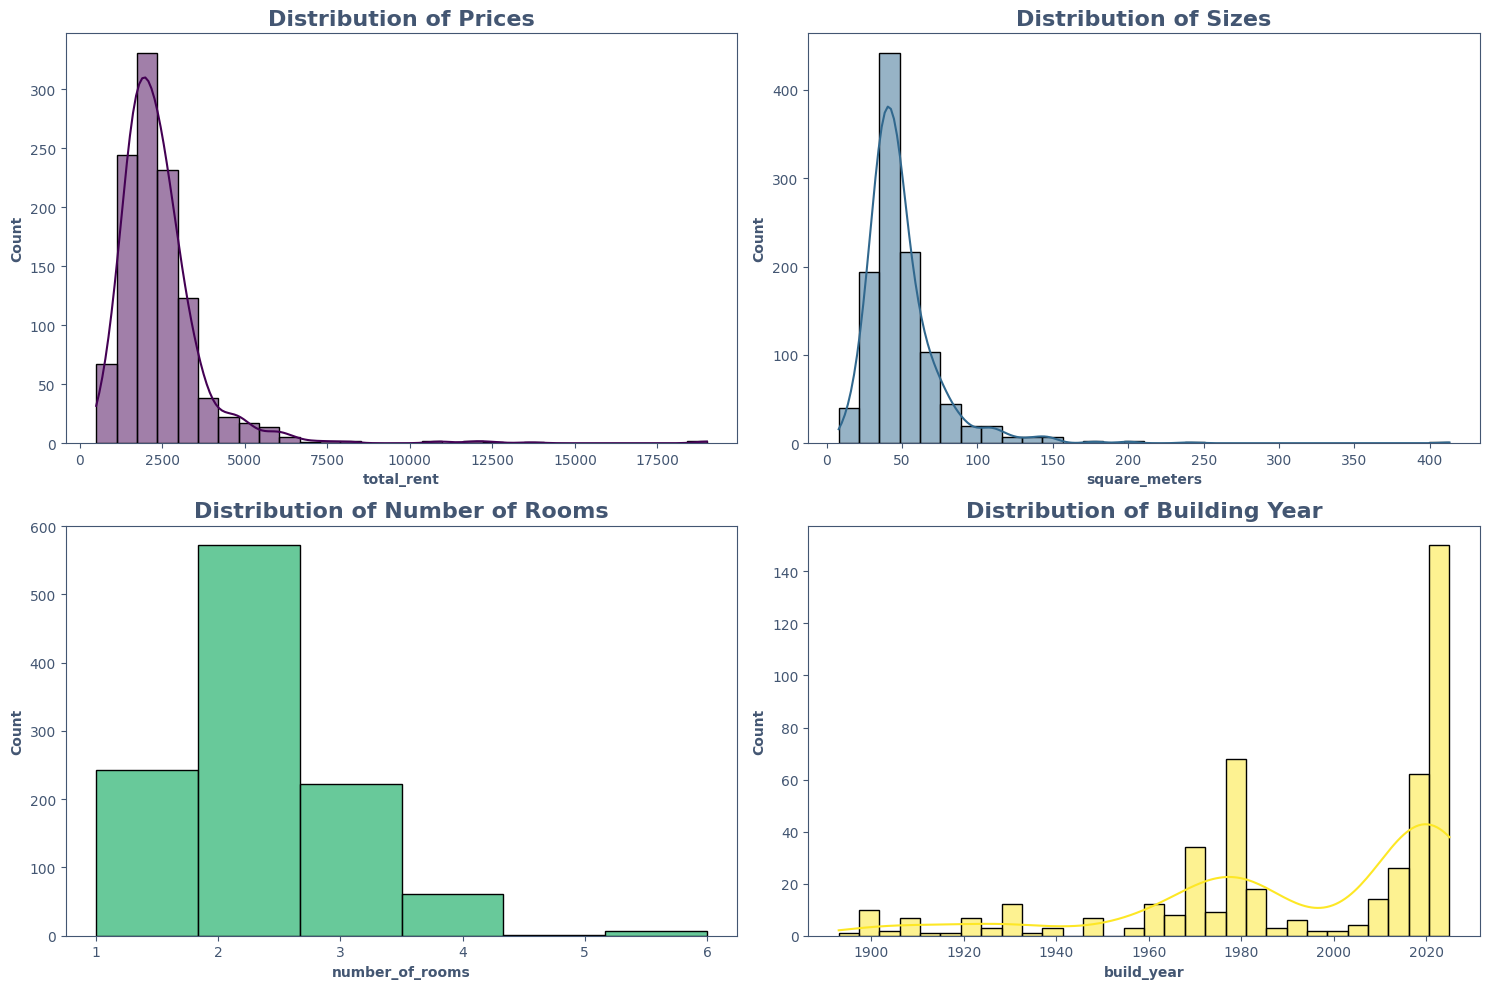

In [16]:
aesthetics_plots = {
	'title_size': 16,
    'y_and_x_label_size': 12,
	'fontweight': 'bold',
	'label_color': "#435672",
    "palette": "viridis",
    "figsize": {
        "multiplot": (15, 10),  # (width, height) in inches
        "singleplot": (8, 6),
        },
    }


def set_plot_aesthetics(
        ax: plt.Axes, 
        title: str, 
        title_fontsize: int = aesthetics_plots['title_size'], 
        color: str =aesthetics_plots['label_color'], 
        fontweight: str =aesthetics_plots['fontweight']
    ):


    ax.set_title(title, fontsize=title_fontsize, color=color, fontweight=fontweight)
    ax.set_xlabel(ax.get_xlabel(), fontweight=fontweight)
    ax.set_ylabel(ax.get_ylabel(), fontweight=fontweight)
    ax.tick_params(colors=color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(color)  # Y-axis label color
    ax.xaxis.label.set_color(color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(color)

def plot_distribution(combined_df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=aesthetics_plots['figsize']['multiplot'])

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))

    titles = ['Distribution of Prices', 'Distribution of Sizes', 'Distribution of Number of Rooms', 'Distribution of Building Year']
    data_columns = ['pricing.total_rent', 'size.square_meters', 'size.number_of_rooms', 'type_and_year.build_year']
    kde_settings = [True, True, False, True]
    bins = [30, 30, 6, 30]

    for ax, title, color, data_column, kde_setting, bin in zip(axes.flat, titles, colors, data_columns, kde_settings, bins):
        sns.histplot(combined_df[data_column.split('.')[0]][data_column.split('.')[1]].astype('float'), ax=ax, kde=kde_setting, bins=bin, color=color)
        set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(combined_df)

**Insights Top Numerical Data:**

1. **Rental Prices**:<br>
Most rents are low, with a common amount around `2500`. There aren't many pricey places to rent.

1. **Apartment Sizes**:<br>
Smaller apartments are more common (around `50 m2`) than larger ones, with very few big apartments available.
Most have only `2` rooms extra besides the bathroom and kitchen or corridor.

1. **Building Ages**:<br>
A lot of buildings were put up around the year `1980`, and there's a recent surge in new ones in `2020`.<br>
You don't see many old buildings up for rent.

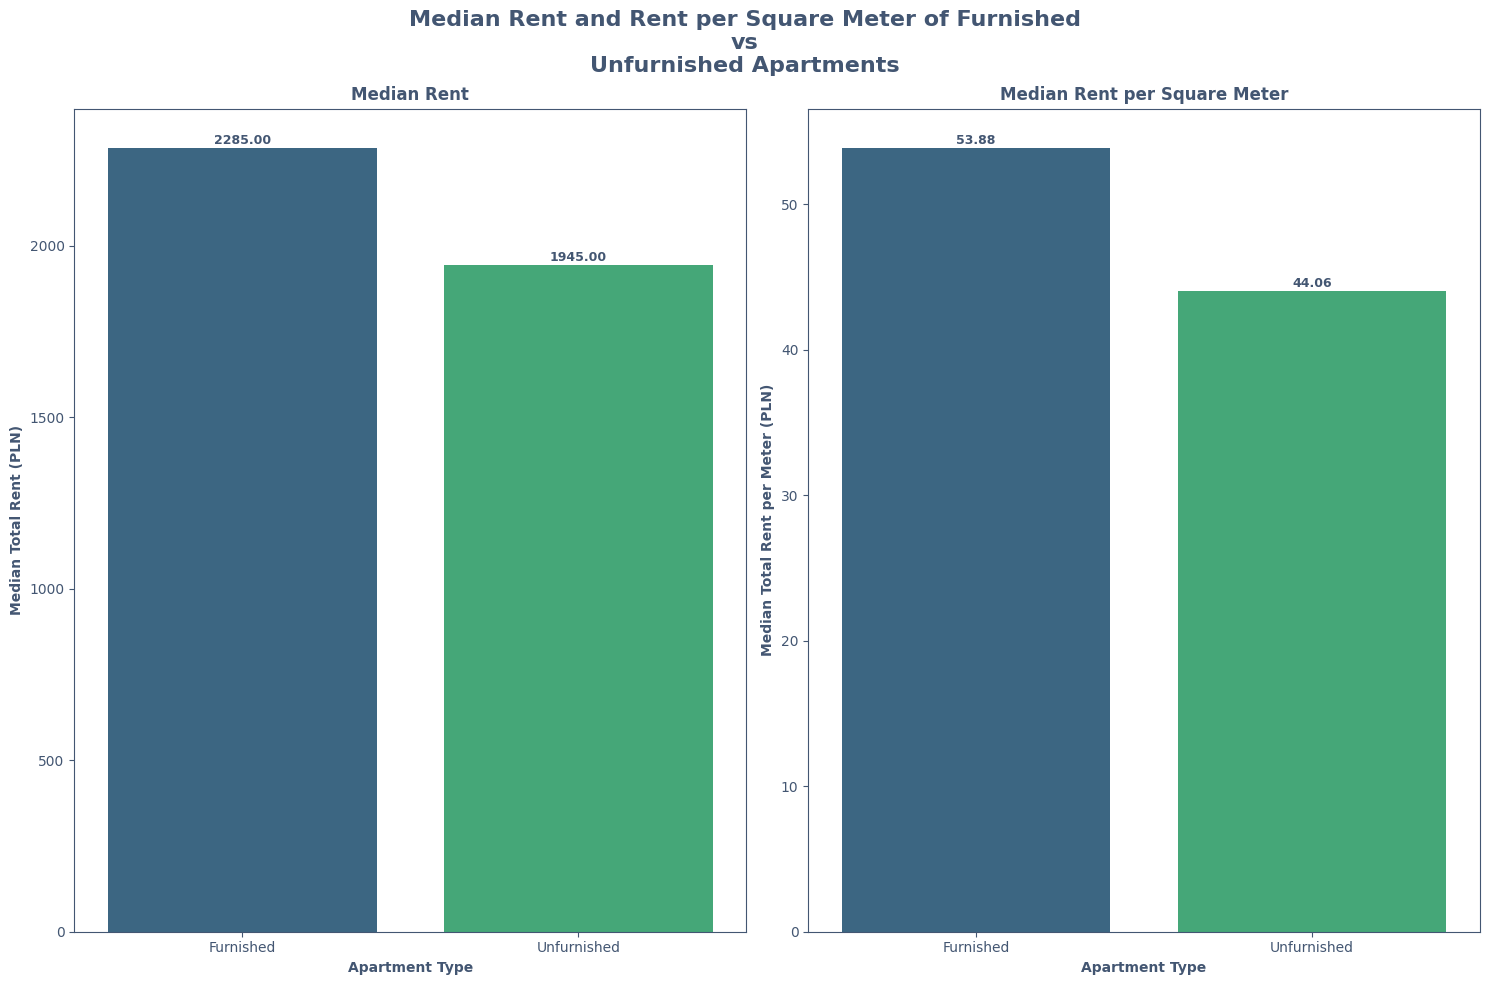

Median Differences:
Furnished vs Unfurnished: 340.0 PLN
Furnished vs Unfurnished per Square Meter: 10.0 PLN


In [17]:
def set_plot_aesthetics(ax, title=None, xlabel=None, ylabel=None, title_color="#435672", tick_color="#435672", fontweight='bold'):
    if title:
        ax.set_title(title, color=title_color, fontweight=fontweight)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight=fontweight)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight=fontweight)
    ax.tick_params(colors=tick_color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(tick_color)  # Y-axis label color
    ax.xaxis.label.set_color(tick_color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(tick_color)

def plot_distribution(combined_df: pd.DataFrame):

    # No information about furniture delete
    # refactor

    # Calculate medians
    median_furnished = combined_df[combined_df['equipment']['furniture']]['pricing']['total_rent'].median()
    median_unfurnished = combined_df[~combined_df['equipment']['furniture']]['pricing']['total_rent'].median()
    
    median_furnished_sqm = (combined_df[combined_df['equipment']['furniture']]['pricing']['total_rent_sqm']).median()
    median_unfurnished_sqm = (combined_df[~combined_df['equipment']['furniture']]['pricing']['total_rent_sqm']).median()

    # Prepare data for plotting
    median_data_furnishing = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent': [median_furnished, median_unfurnished]
    })

    median_data_square_meter = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent per Square Meter': [median_furnished_sqm, median_unfurnished_sqm]
    })

    title = 'Median Rent and Rent per Square Meter of Furnished\nvs\nUnfurnished Apartments'

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=aesthetics_plots['figsize']['multiplot'])

    # Plotting Median Rent
    sns.barplot(x='Furniture', y='Median Rent', data=median_data_furnishing, ax=ax1, palette='viridis')

    # Plotting Median Rent per Square Meter
    sns.barplot(x='Furniture', y='Median Rent per Square Meter', data=median_data_square_meter, ax=ax2, palette='viridis')

    for ax in [ax1, ax2]:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], fontweight='bold',
                        xytext=(0, 5),
                        textcoords='offset points')
            
    # Apply aesthetics to each subplot
    set_plot_aesthetics(ax1, title='Median Rent', xlabel='Apartment Type', ylabel='Median Total Rent (PLN)')
    set_plot_aesthetics(ax2, title='Median Rent per Square Meter', xlabel='Apartment Type', ylabel='Median Total Rent per Meter (PLN)')

    # Set the main title for the figure
    fig.suptitle(title, color="#435672", fontsize=aesthetics_plots['title_size'], fontweight='bold')


    plt.tight_layout()
    plt.show()

    print(f"Median Differences:")
    print(f"Furnished vs Unfurnished: {abs(median_furnished - median_unfurnished)} PLN")
    print(f"Furnished vs Unfurnished per Square Meter: {(abs(median_furnished_sqm - median_unfurnished_sqm)).round()} PLN")

plot_distribution(combined_df)

**Insights Median Prices Furnishes vs Unfurnished:**

1. **Higher Median Rent for Furnished Apartments**:<br>
Furnished apartments have a higher median rent compared to unfurnished ones by 340 PLN.<br>
This suggests that renters pay a premium for the added convenience of a furnished space.

1. **Smaller Difference in Price per Square Meter**:<br>
When looking at the rent price per square meter,<br>
furnished apartments are only about 10 PLN more expensive than unfurnished ones.<br>
This smaller difference implies that the size of an apartment doesn't drastically affect the furnished rent premium.

In [18]:
def show_categorical_data_percentage_distribution(
        df: pd.DataFrame, 
        categorical_column: Tuple[str, str], 
        distribution_column: Tuple[str, str], 
        title: str,
        x_ticks_number: int = 10,
        y_ticks_number: int = 8,
        x_ticks_rotation: bool = True,
        y_ticks_rotation: bool = True,
    ):
    
    # Create a subset DataFrame with only the required columns
    plot_data = df[[categorical_column, distribution_column]].dropna()

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 7))

    # Get unique building types from the categorical column
    building_types = plot_data[categorical_column].unique()

    # Generate a list of colors, one for each building type
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f'] + ["#FF9F66"]

    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.

    # Plot each building type's histogram
    for building_type, color in zip(building_types, my_palette):
        # Select the rows where the building type matches and is not null
        subset = plot_data[plot_data[categorical_column] == building_type]
        sns.histplot(subset[distribution_column], kde=False, color=color, label=building_type, ax=ax)

    
    # Add some formatting and titles
    x_axis_title = distribution_column[1].replace('_', ' ')

    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel(x_axis_title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Frequency', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    legend = plt.legend(title=x_axis_title)
    plt.setp(legend.get_title(), fontsize='large', color=aesthetics_plots['label_color'], weight='bold')
    plt.setp(legend.get_texts(), color=aesthetics_plots['label_color'])

    # Customize x-axis ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=x_ticks_number))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=y_ticks_number))

    if x_ticks_rotation:
        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    if y_ticks_rotation:
        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add annotations for each bar
    for p in ax.patches:
        # Calculate the percentage of the total
        percentage = (p.get_height() / len(df)) * 100
        # Place the annotation above the bar
        if percentage > 0:
            ax.annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color=aesthetics_plots['label_color'], xytext=(0, 8),
                        textcoords='offset points')

    # Show the plot
    plt.show()

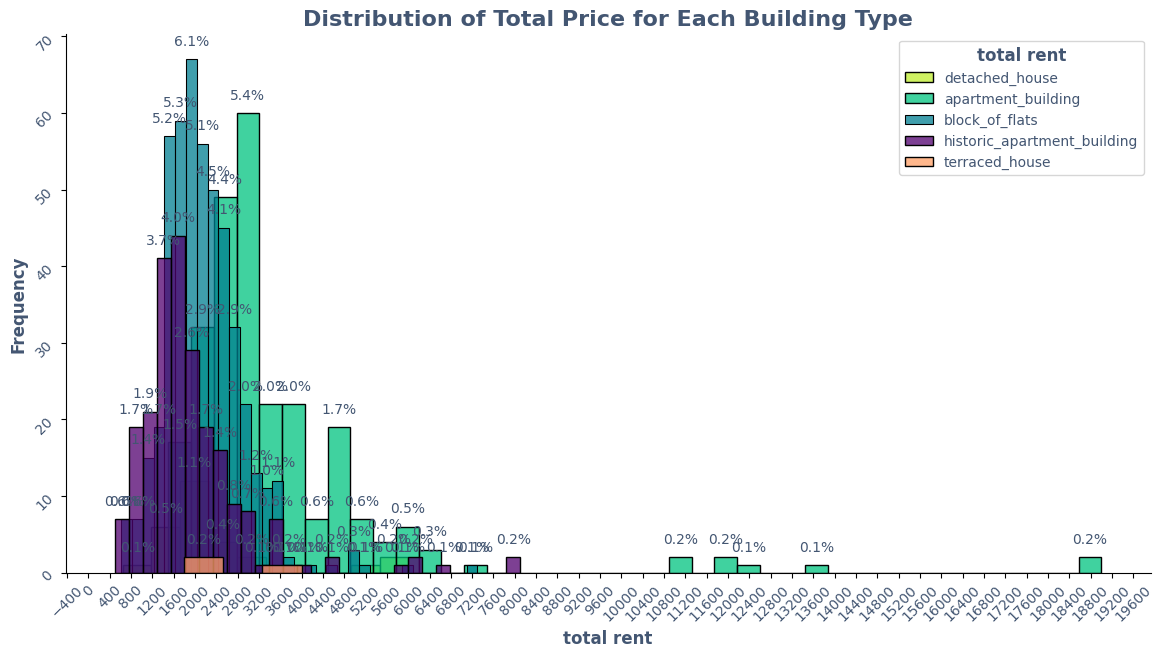

In [19]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('type_and_year', 'building_type'),
    ('pricing', 'total_rent'),
    'Distribution of Total Price for Each Building Type',
    x_ticks_number= 60,
    x_ticks_rotation= True
    )

**Insights from Distribution of Total Price for Each Building Type**:
1. **Apartment buildings**:<br>
have a wide price distribution from `400` to `8000`, with a notable concentration between the range of `400` to `3.200`, most low budget-friendly offers in the data.

1. **Block of Flats**:<br>
Prices for blocks of flats show a slightly wider spread in the histogram, extending into the mid-price range (`800` to `3600`) and some outliers (`4800` to `5000`). The presence in both lower and mid-range pricing suggests a mix of both economical and upscale options for renters.

1. **Historic Apartment Buildings**:<br>
The distribution for historic apartment buildings tends to stretch across a broad range of prices (`400` to `3600`), with some properties listed at the higher end (`4000`, `5600`, `6000`, `8000`).

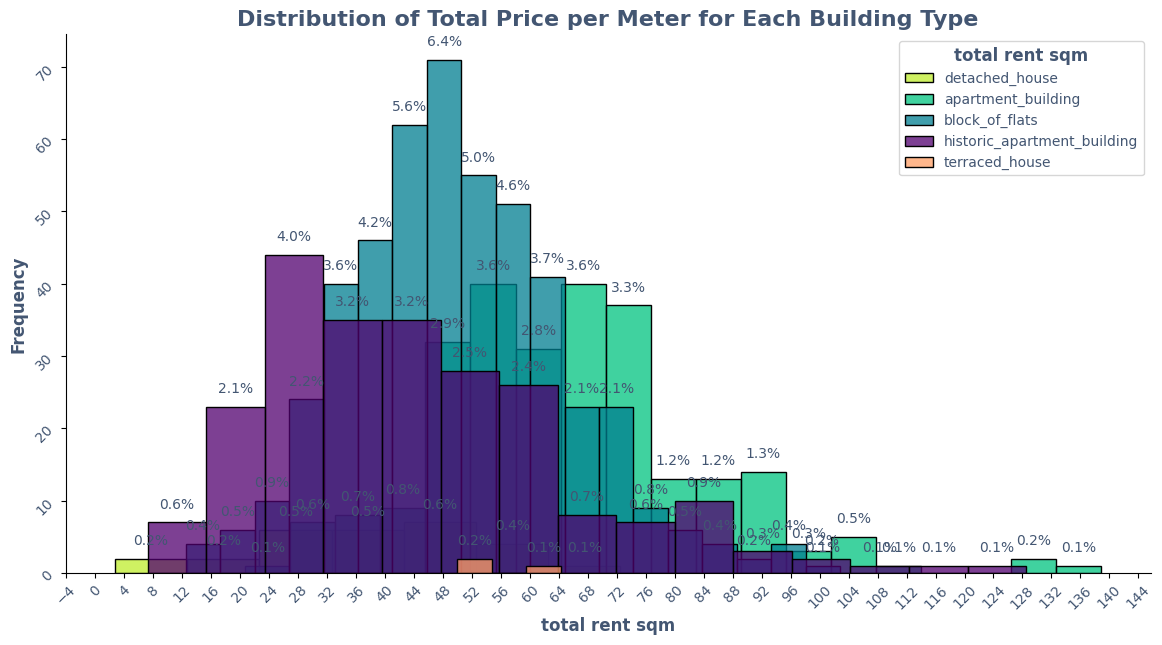

In [20]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('type_and_year', 'building_type'),
    ('pricing', 'total_rent_sqm'),
    'Distribution of Total Price per Meter for Each Building Type',
    x_ticks_number= 40,
    x_ticks_rotation= True
    )

**Insights from Distribution of Total Price per Meter for Each Building Type**:

1. **The total price per meter for apartment buildings**:<br>
is concentrated heavily around `50 PLN per sqm`.
1. **Historic apartment buildings**:<br>
show a price per meter spread over a wider range, more in the lower end and high end (`8` to `128`) in the peak around `24`.
1. **Terraced houses**:<br>
 while less common, show a consistently lower price per meter (`4` to `24`), suggesting higher space for a lower per meter price.

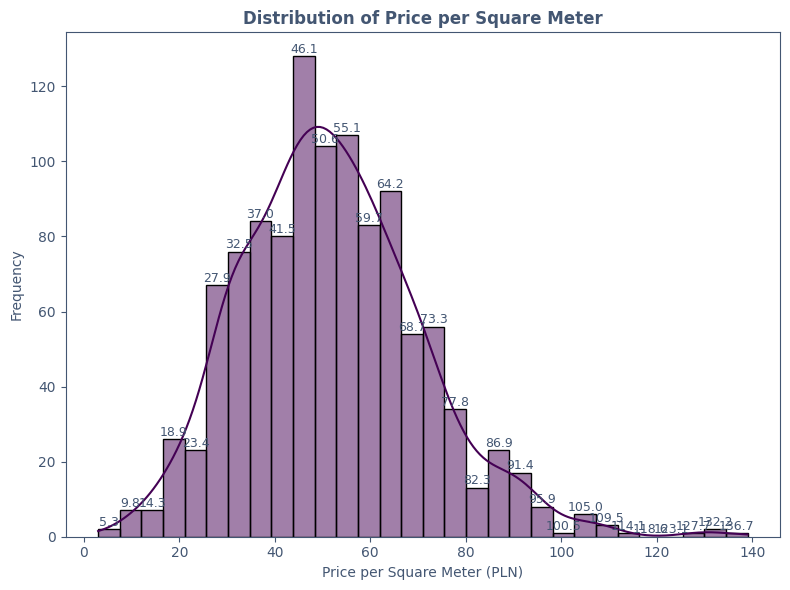

In [21]:
def plot_distribution(combined_df: pd.DataFrame):

    # Calculation with handling of potential division by zero or NaN values
    plot_data = combined_df['pricing']['total_rent_sqm']
    plot_data = plot_data.dropna().round().astype('float')

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))
    color = colors[0]
    title = 'Distribution of Price per Square Meter'

    fig, ax = plt.subplots(figsize=aesthetics_plots['figsize']['singleplot'])
    hist = sns.histplot(plot_data, kde=True, bins=30, color=color, ax=ax)
    ax.set_xlabel('Price per Square Meter (PLN)')
    ax.set_ylabel('Frequency')

    for p in hist.patches:
        bin_center = p.get_x() + p.get_width() / 2
        ax.annotate(f'{bin_center:.1f}', (bin_center, p.get_height()), 
                    ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], xytext=(0, 5),
                    textcoords='offset points')
        
    set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(combined_df)

**Insights Price Per Square Meter:**

1. **Common Rent Prices**:<br>
Most apartments cost about `50 PLN` for each `square meter`.<br>
It's less common to find apartments that charge a lot more than this per square meter.

1. **Few Expensive Places**:<br>
The chart stretches out to the right, showing that while a few apartments have really high rent for each square meter,<br>
they're pretty rare. Most places stick close to the usual cost.

In [22]:
CategoryResults = list[Tuple[str, str, float]]

def get_correlations(data: pd.DataFrame):
    
    def get_correlation_category(bottom_threshold: float, upper_threshold: float = 1.0):

        category_results: CategoryResults = []
        num_columns = len(columns)

        for i in range(num_columns):
            for j in range(i+1, num_columns):

                corr_value = correlations.iloc[i, j]
                col_left = columns[i]
                col_right = columns[j]

                category_results = add_correlation_value(
                        bottom_threshold, 
                        upper_threshold, 
                        category_results, 
                        corr_value, 
                        col_left, 
                        col_right
                    )
        
        sorted_results = sorted(category_results, key=lambda x: x[2], reverse=True)
        return sorted_results

    def add_correlation_value(
                bottom_threshold: float, 
                upper_threshold: float, 
                category_results: CategoryResults, 
                corr_value: float, 
                col_left: str, 
                col_right: str
            ):

        if upper_threshold == 1.0:
            if bottom_threshold <= abs(corr_value):
                category_results.append((col_left, col_right, corr_value))
        else:
            if bottom_threshold <= abs(corr_value) < upper_threshold:
                category_results.append((col_left, col_right, corr_value))

        return category_results
    
    correlations = data.corr()
    columns = correlations.columns
    correlations_results = {}
    
    correlations_results['Strong Correlations'] = get_correlation_category(bottom_threshold = 0.7)
    correlations_results['Moderate Correlations'] = get_correlation_category(bottom_threshold = 0.3, upper_threshold = 0.7)
    correlations_results['Weak Correlations'] = get_correlation_category(bottom_threshold = 0.1, upper_threshold = 0.3)

    return correlations_results

def print_results(correlations_results: dict[str, CategoryResults]):

    for level, results in correlations_results.items():
        print(f"\n{level}:")
        for col_left, col_right, corr_value in results:
            print(f"{col_left} - {col_right}: {round(corr_value, 2)}")
        print("\r")

def print_correlations(data: pd.DataFrame):
    
    correlations_results = get_correlations(data)
    
    print_results(correlations_results)

def get_top_extreme_results(correlations_results: dict[str, CategoryResults], column_of_interest: str, num_positive_negative: int):

    top_positive = []

    positive_count = 0

    for _, results in correlations_results.items():

        for col_left, col_right, corr_value in results:

            if corr_value > 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if positive_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_positive.append(corr_item)

                    positive_count += 1

        if positive_count == num_positive_negative:
            break

    top_negative = []

    negative_count = 0

    reversed_dict = dict(reversed(correlations_results.items()))

    for _, results in reversed_dict.items():

        for col_left, col_right, corr_value in results:

            if corr_value < 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if negative_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_negative.insert(0, corr_item)

                    negative_count += 1

        if negative_count == num_positive_negative:
            break

    top_positive.extend(top_negative)

    return top_positive

In [23]:

def show_extreme_correlations(data: pd.DataFrame, column_of_interest: Tuple[str, str], num_results: int = 5, title: str = "Add title"):

    columns_to_drop = [('pricing', 'price'), ('pricing', 'rent')]
    data = data.drop(columns=columns_to_drop)
    correlations_results = get_correlations(data)
    extreme_correlations = get_top_extreme_results(correlations_results, column_of_interest, num_results)

    unique_elements = list(
        set([item[0] for item in extreme_correlations] + [item[1] for item in extreme_correlations])
    )
    correlation_values = np.zeros((len(unique_elements), len(unique_elements)))

    element_index_mapping = {
        element: index for index, element in enumerate(unique_elements)
    }

    for item in extreme_correlations:
        col1, col2, corr_value = item
        row_index = element_index_mapping[col2]
        col_index = element_index_mapping[col1]
        correlation_values[row_index, col_index] = corr_value

    df = pd.DataFrame(correlation_values, index=unique_elements, columns=unique_elements)
    df_column_of_interest = df[[column_of_interest]]
    df_no_empty_value = df_column_of_interest.drop(index=column_of_interest)
    df_no_0 = df_no_empty_value.drop(df_no_empty_value[df_no_empty_value.eq(0).all(axis=1)].index)
    df_plot = df_no_0.sort_values(by=column_of_interest, ascending=False)

    with plt.style.context('seaborn'):
        plt.figure(figsize=aesthetics_plots['figsize']['singleplot'])
        heatmap = sns.heatmap(df_plot, cmap='coolwarm', vmin = -1.0, vmax = 1.0, annot=True, fmt=".2f", annot_kws={'color': "white", 'fontweight': "bold"}, cbar=True, cbar_kws={"label": "Correlation"})
        # set color palette proportional to values 1.0 is always max 0.0 always least color value
        heatmap.set_xlabel("")
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, color=aesthetics_plots['label_color'])
        heatmap.set_xticklabels([])
        
        # Add the following lines
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([heatmap.collections[0].get_array().min(), heatmap.collections[0].get_array().max()])
        cbar.set_ticks([-1.0, 0, 1.0])  # Set the tick locations
        cbar.set_ticklabels(['-1.0', '0.0', '1.0'])  # Set the tick labelss
        cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color=aesthetics_plots['label_color'])  # Set the tick label color
        cbar.set_label("Correlation", color=aesthetics_plots['label_color'])
        
        plt.title(f'Correlation: {title}\n', color=aesthetics_plots['label_color'], fontsize = aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
        plt.show()


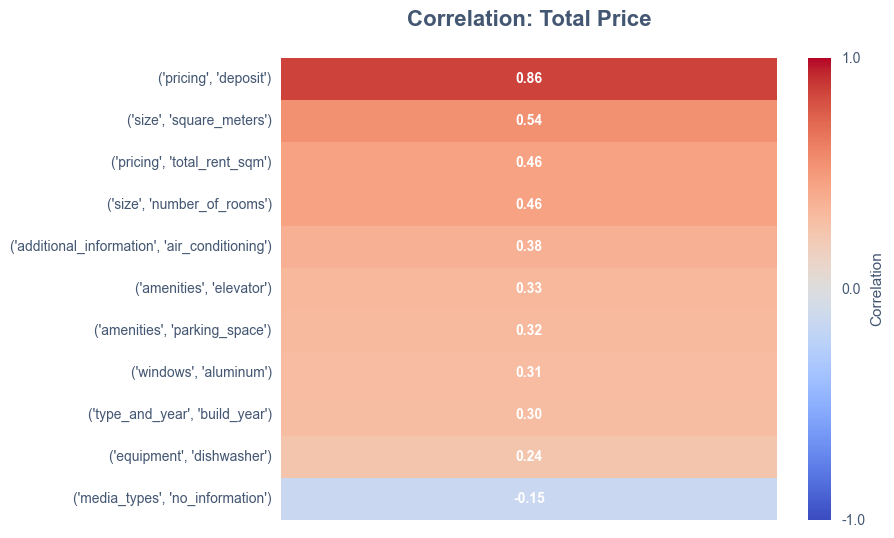

In [24]:
show_extreme_correlations(combined_df, ('pricing', 'total_rent'), num_results = 10, title="Total Price")

**Insights Total Price Correlations:**

1. **Deposit and Total Price**:<br>
There is a strong positive relationship between the deposit amount and the total price, indicated by a correlation of `0.86`.<br>
This suggests that higher-priced rentals typically require a higher deposit.

1. **Size Matters**:<br>
The apartment size, measured in square meters, has a significant positive correlation `(0.54)` with the total price,<br>
meaning larger apartments tend to be more expensive.<br>
The number of rooms also shows a positive correlation `(0.46)` with price, though it's not as strong as the size in square meters,<br>indicating that the overall size may be more influential on price than the mere number of rooms.

1. **Features and Lack of Information**:<br>
Additional features like air conditioning have a moderate positive correlation `(0.38)` with total price,<br>
implying that apartments with air conditioning might be priced higher.<br>
Interestingly, there's a slight negative correlation `(-0.15)` with 'no information' provided in media types,<br>
which could suggest that listings with less information may be associated with slightly lower prices,<br>
or it might indicate a trend where less expensive listings provide fewer details.

Other correlations:

In [25]:
print_correlations(combined_df)


Strong Correlations:
('pricing', 'price') - ('pricing', 'total_rent'): 0.98
('equipment', 'stove') - ('equipment', 'fridge'): 0.89
('equipment', 'fridge') - ('equipment', 'washing_machine'): 0.89
('pricing', 'price') - ('pricing', 'deposit'): 0.88
('pricing', 'total_rent') - ('pricing', 'deposit'): 0.86
('equipment', 'stove') - ('equipment', 'washing_machine'): 0.85
('equipment', 'stove') - ('equipment', 'oven'): 0.84
('equipment', 'fridge') - ('equipment', 'oven'): 0.78
('equipment', 'oven') - ('equipment', 'washing_machine'): 0.76
('media_types', 'internet') - ('media_types', 'cable_TV'): 0.73
('size', 'floor') - ('size', 'building_floors'): 0.71
('media_types', 'no_information') - ('media_types', 'cable_TV'): -0.79
('security', 'no_information') - ('security', 'intercom_or_video_intercom'): -0.85
('equipment', 'no_information') - ('equipment', 'furniture'): -0.87
('windows', 'no_information') - ('windows', 'plastic'): -0.93
('media_types', 'no_information') - ('media_types', 'inter

**Insights Other Correlations:**

1. **Price Consistency**:<br>
The almost perfect correlation `(0.98)` between `'pricing`' and `'price'` vs. `'total_rent'` suggests that the rent price consistently contributes to the total cost of renting, likely inclusive of additional fees or services.

1. **Equipment Bundling**:<br>
The strong correlations among various pieces of equipment (stove, fridge, washing machine, oven) ranging from `0.78` to `0.89` indicate that these are often bundled together in rental properties. If a rental has one of these appliances, it's very likely to have the others.

1. **Safety and Convenience Features**:<br>
There is a moderate positive correlation (`0.68` to `0.64`) between having certain appliances (stove, fridge, washing machine) and security features like intercom or video intercom systems. This could imply that properties equipped with modern conveniences also prioritize security.

### 2.3 Location

In [26]:
def count_and_percentage_with_distance(df, column_name, city_coords, city_populations):

    # Flatten the index to avoid groupby issues
    df_temp = pd.DataFrame()
    df_temp[str(column_name)] = df[column_name]
    column_name = str(column_name)
    df_temp['median_price (PLN)'] = df[('pricing', 'total_rent')]
    df_temp['square_meters'] = df[('size', 'square_meters')]
    df_temp['median_total_rent_sqm (PLN)'] = df[('pricing', 'total_rent_sqm')]

    if column_name not in df_temp.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Calculate count and percentage
    count = df_temp[column_name].value_counts(dropna=False)
    percentage = df_temp[column_name].value_counts(dropna=False, normalize=True) * 100

    # Create a DataFrame from the count and percentage
    result = pd.DataFrame({
        'Count': count,
        'Percentage': percentage
    }).reset_index()

    # Rename the 'index' column to the actual column name for clarity
    result.rename(columns={'index': column_name}, inplace=True)

    # Add median ('pricing', 'total_rent')
    grouped = df_temp.groupby(column_name)
    median_rent = grouped['median_price (PLN)'].median()
    median_sqm = grouped['square_meters'].median()
    median_sqm_rent = grouped['median_total_rent_sqm (PLN)'].median()

    result = result.join(median_rent, on=column_name)
    result = result.join(median_sqm, on=column_name)
    result = result.join(median_sqm_rent, on=column_name)

    # Calculate the distance from the central city for each city
    central_city = 'Mierzęcice, Będziński, Śląskie'
    central_city_coords = city_coords['central_city'][central_city]
    
    result[f'Distance from {central_city} (km)'] = result.apply(
        lambda row: round(haversine(central_city_coords, city_coords['distance_from_central_city'].get(row[column_name], (None, None)), unit='km'), 2)
        if row[column_name] in city_coords['distance_from_central_city'] else None, axis=1)

    # Add city population information
    result['City Population (Thousands)'] = result[column_name].map(city_populations)

    return result

In [27]:
city_populations = {
    "Katowice": 286,
    "Sosnowiec": 191,
    "Bytom": 161,
    "Dąbrowa Górnicza": 116,
    "Chorzów": 105,
    "Jaworzno": 89,
    "tarnogórski": 45, # Rular area
    "będziński": 38, # Rular area
    "Siemianowice Śląskie": 65,
    "Mysłowice": 72,
    "Piekary Śląskie": 54,
    "Świętochłowice": 49,
    "Ruda Śląska": 135,
    "myszkowski": 32, # Rular area
    "częstochowski": 119, # Rular area
    "zawierciański": 43,  # Rular area
    "Zawada": 0.16  # Rular area
}

city_coords = {
    "central_city": {
        "Mierzęcice, Będziński, Śląskie": (50.4441, 19.12405)
    },
    "distance_from_central_city": {
        "Katowice": (50.258598, 19.020420),
        "Sosnowiec": (50.286263, 19.104078),
        "Bytom": (50.348160, 18.917561),
        "Dąbrowa Górnicza": (50.325910, 19.187200),
        "Chorzów": (50.297642, 18.955420),
        "Jaworzno": (50.203439, 19.272156),
        "tarnogórski": (50.444241, 18.856491),
        "będziński": (50.415352, 19.11304),
        "Siemianowice Śląskie": (50.30563, 19.028088),
        "Mysłowice": (50.209621, 19.132166),
        "Piekary Śląskie": (50.375779, 18.937939),
        "Świętochłowice": (50.298945, 18.907466),
        "Ruda Śląska": (50.270348, 18.864388),
        "myszkowski": (50.605529, 19.294746),
        "częstochowski": (50.7979, 19.1247),
        "zawierciański": (50.54427, 19.619602),
        "Zawada": (50.43734, 19.096938),
    }
}

locations_summary = count_and_percentage_with_distance(combined_df, ("location", "city"), city_coords, city_populations)
locations_summary

,"('location', 'city')",Count,Percentage,median_price (PLN),square_meters,median_total_rent_sqm (PLN),"Distance from Mierzęcice, Będziński, Śląskie (km)",City Population (Thousands)
0,Katowice,514,46.473779,2600.0,45.0,59.302885,21.90,286.00
1,Sosnowiec,145,13.110307,2000.0,44.0,47.368421,17.61,191.00
2,Bytom,122,11.030741,1610.0,41.5,40.186275,18.11,161.00
3,Dąbrowa Górnicza,68,6.148282,2200.0,46.5,49.397559,13.88,116.00
4,Chorzów,61,5.515371,1800.0,39.0,45.444444,20.21,105.00
5,Jaworzno,36,3.254973,1800.5,40.0,45.369643,28.75,89.00
6,tarnogórski,33,2.983725,1986.0,48.0,42.5,18.95,45.00
7,będziński,32,2.893309,1965.0,44.0,49.060484,3.29,38.00
8,Siemianowice Śląskie,23,2.079566,1750.0,42.0,43.793103,16.83,65.00
9,Mysłowice,21,1.898734,2000.0,52.0,43.243243,26.08,72.00


In [28]:
locations_summary[["('location', 'city')", "median_price (PLN)", "median_total_rent_sqm (PLN)"]].sort_values(by="median_total_rent_sqm (PLN)", ascending=False)

,"('location', 'city')",median_price (PLN),median_total_rent_sqm (PLN)
16,Zawada,1900.0,73.076923
0,Katowice,2600.0,59.302885
3,Dąbrowa Górnicza,2200.0,49.397559
7,będziński,1965.0,49.060484
1,Sosnowiec,2000.0,47.368421
4,Chorzów,1800.0,45.444444
5,Jaworzno,1800.5,45.369643
8,Siemianowice Śląskie,1750.0,43.793103
9,Mysłowice,2000.0,43.243243
6,tarnogórski,1986.0,42.5


**Insights Location and Price**:

1. **Higher Rents in Larger Cities**:<br>
Katowice, the largest city with `286,000 people`, leads in both the number of listings `(514)` and rent prices. It has a median rent of `2600 PLN` and a price of `57.78 PLN` per square meter. This shows that in bigger cities like Katowice, living costs, including rent, are generally higher.

1. **Rent Increases with City Size**:<br>
In larger cities, rent tends to be pricier. For example, `Katowice` and `Sosnowiec`, with larger populations, have median rents of `2600 PLN` and `2000 PLN`, respectively. In contrast, smaller areas like `Zawiercie` and `Myszkowski` have significantly lower rents.

1. **Location's Influence on Rent**:<br>
The distance from `Mierzęcice`, `Będziński, Śląskie` impacts rent. Closer locations like `Będziński` (`3.29 km` away) have a lower price per square meter (`44.66 PLN`) compared to further cities like `Jaworzno` (`28.75 km` away) with `45.01 PLN` per square meter. This indicates that proximity to a central point can influence rental prices.

In [29]:
geolocator = Nominatim(user_agent="your_app_name")

def get_coordinates(address, attempt=1, max_attempts=3):
    try:
        location = geolocator.geocode(address, timeout=10)  # Increase timeout to 10 seconds
        if location:
            return (location.latitude, location.longitude)
        else:
            return (None, None)
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            time.sleep(1 * attempt)  # Exponential backoff
            return get_coordinates(address, attempt + 1, max_attempts)
        return (None, None)
    except GeocoderUnavailable:
        return (None, None)

def add_geo_data_to_offers(df: pd.DataFrame):

    df_temp = pd.DataFrame()
    df_temp['complete_address'] = df[('location', 'complete_address')]
    df_temp['city'] = df[('location', 'city')] + ", " + df[('location', 'voivodeship')]
    df_temp['price_total'] = df[('pricing', 'total_rent')]
    df_temp['price'] = df[('pricing', 'price')]
    df_temp['rent'] = df[('pricing', 'rent')]
    df_temp['rent_sqm'] = df[('pricing', 'total_rent_sqm')]
    df_temp['sqm'] = df[('size', 'square_meters')]
    df_temp['is_furnished'] = df[('equipment', 'furniture')]

    # Create unique address list
    unique_addresses = df[('location', 'complete_address')].unique()
    address_coords = {}

    for address in unique_addresses:
        coords = get_coordinates(address)
        if coords == (None, None):
            # If coordinates for the complete address are not found, try with city
            city = df_temp[df_temp['complete_address'] == address]['city'].values[0]
            coords = get_coordinates(city)
        address_coords[address] = coords

    # Map the coordinates back to the DataFrame
    df_temp['coords'] = df_temp['complete_address'].map(address_coords)

    return df_temp

# map_df = add_geo_data_to_offers(combined_df) # Takes a while to run due to server requests latency
# data_path_manager.save_df(map_df, "map")

In [30]:
map_df = data_path_manager.load_df("map", is_cleaned=True)

In [31]:
print("Unique geo coordinates:")
len(map_df['coords'].unique())

Unique geo coordinates:


112

In [32]:
def show_property_map(
        map_df: pd.DataFrame, title: str = "", 
        center_coords: tuple[float, float] = None, 
        center_marker_name: str = "Mierzęcice, Będziński, Śląskie", 
        zoom: float = 10.0
        ):
    
    def extract_lat_lon(coord):
        coord_parts = coord.strip('()').split(', ')
        coord_tuple = tuple(float(part) if part.strip() != "None" else None for part in coord_parts)
        return coord_tuple

    def create_heatmap_data(plot_data: pd.DataFrame) -> go.Figure:
        
        def get_hovertemplate(row):

            labels = ["City:", "Complete Address:", "Total Price:", "Price:", "Rent:", "Square Meters:", "Price/Sqm:", "Furnished:"]
            max_label_length = max(len(label) for label in labels)
            font_style = "font-family:monospace;"

            return (
                f"<span style='{font_style}'>{'City:'.ljust(max_label_length)}</span> {row['city']}<br>"
                f"<span style='{font_style}'>{'Street:'.ljust(max_label_length)}</span> {row['complete_address'].replace((', ' + row['city']), '') if row['city'] else row['complete_address']}<br>"
                f"<span style='{font_style}'>{'Total Price:'.ljust(max_label_length)}</span> {row['price_total']}<br>"
                f"<span style='{font_style}'>{'Price:'.ljust(max_label_length)}</span> {row['price']}<br>"
                f"<span style='{font_style}'>{'Rent:'.ljust(max_label_length)}</span> {row['rent']}<br>"
                f"<span style='{font_style}'>{'Square Meters:'.ljust(max_label_length)}</span> {row['sqm']}<br>"
                f"<span style='{font_style}'>{'Price/Sqm:'.ljust(max_label_length)}</span> {row['rent_sqm']}<br>"
                f"<span style='{font_style}'>{'Furnished:'.ljust(max_label_length)}</span> {row['is_furnished']}<extra></extra>"
            )

        offer_counts = plot_data.groupby(['Latitude', 'Longitude']).size().reset_index(name='offer_count')
        plot_data = plot_data.merge(offer_counts, on=['Latitude', 'Longitude'])

        plot_data['hovertemplate'] = plot_data.apply(get_hovertemplate, axis=1)

        return go.Densitymapbox(
            lat=plot_data['Latitude'],
            lon=plot_data['Longitude'],
            z=plot_data['offer_count'],  # Use offer count as density
            radius=10,
            colorscale='Viridis',
            zmin=0,
            zmax=plot_data['offer_count'].max(),  # Maximum count of offers
            hovertemplate=plot_data['hovertemplate'],
            colorbar=dict(
                title='Number<br>of<br>offers:',
            )
        )

    def update_fig(fig: go.Figure, mapbox_zoom: float, mapbox_center: dict):
        fig.update_layout(
            title_text=title,
            mapbox_style='carto-positron',
            mapbox_zoom=mapbox_zoom,
            mapbox_center=mapbox_center,
            margin=dict(l=0, r=0, t=40, b=0),
            coloraxis_colorbar=dict(
                title="Number<br>of<br>offers:",
                title_side='right',
                title_font=dict(size=20),
                y=-2,
                yanchor='middle'
            )
        )
        return fig
    
    map_df['rent_sqm'] = map_df['rent_sqm'].round(2)
    
    lat_lon = map_df['coords'].apply(extract_lat_lon)
    map_df['Latitude'], map_df['Longitude'] = zip(*lat_lon)

    heatmap = create_heatmap_data(map_df)
    fig = go.Figure(data=[heatmap])

    # Determine the center of the map
    if center_coords is None:
        center_coords = {"lat": map_df['Latitude'].mean(), "lon": map_df['Longitude'].mean()}
    else:
        center_coords = {"lat": center_coords[0], "lon": center_coords[1]}
        # Add a pin (marker) at the center coordinates
        fig.add_trace(go.Scattermapbox(
            lat=[center_coords['lat']],
            lon=[center_coords['lon']],
            mode='markers+text',  # Include 'text' in the mode
            marker=go.scattermapbox.Marker(
                size=10,
                color='red'
            ),
            text=[center_marker_name],  # Set the label text
            textposition="bottom right",  # Position the text
            showlegend=False,
        ))

    fig = update_fig(fig, mapbox_center=center_coords, mapbox_zoom=zoom)
    fig.show()

# Example usage
show_property_map(map_df, "Property Prices Heatmap", center_coords=(50.460740, 19.093210), center_marker_name = "Mierzęcice, Będziński, Śląskie", zoom=9)

### 2.4 Attributes and equipment

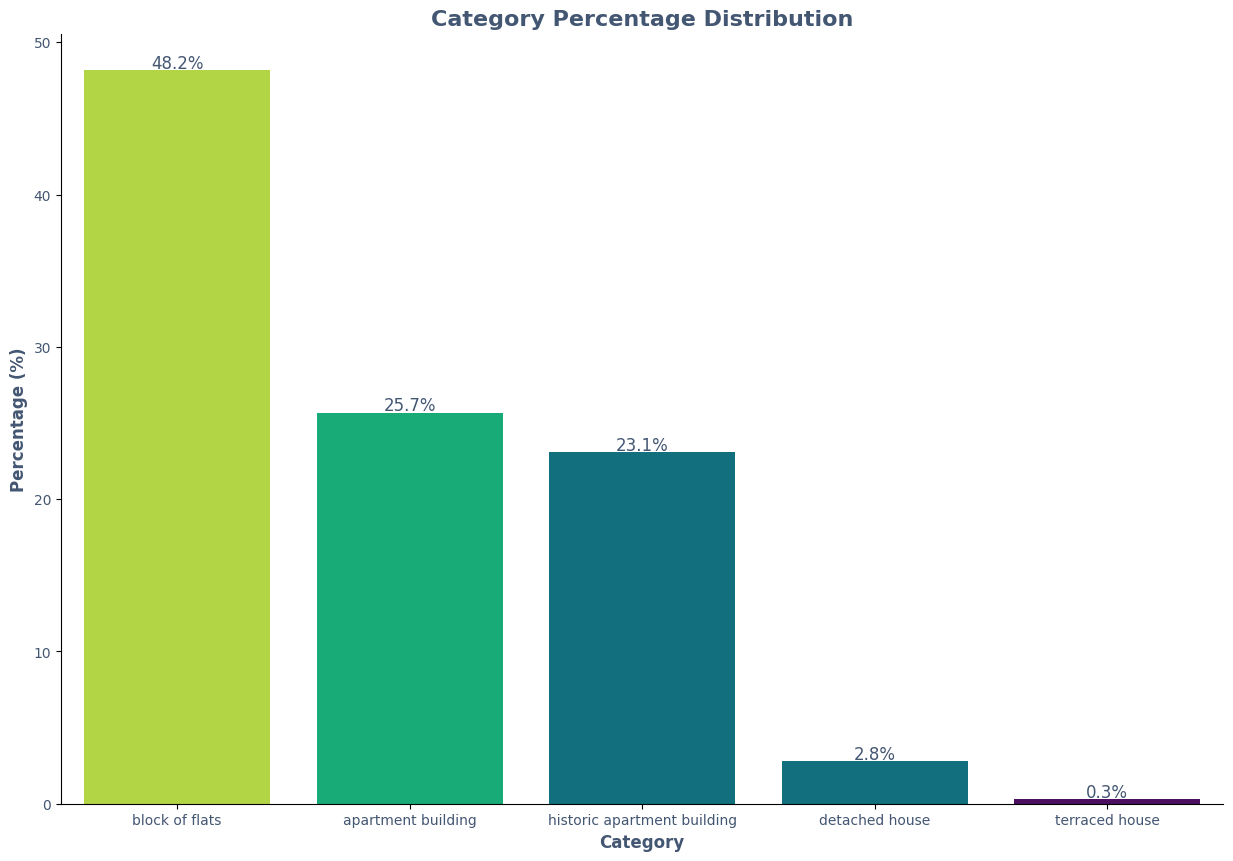

In [33]:
def display_category_proportions(data: pd.Series, title: str):
    # Check if data is a Series and of string type
    if not isinstance(data, pd.Series) or data.dtype != 'string[python]':
        raise TypeError("Data must be a pandas Series with string type.")

    # Calculate the percentage of each category
    category_percentage = data.value_counts(normalize=True) * 100

    # Create a bar plot
    fig, ax = plt.subplots(figsize=aesthetics_plots["figsize"]["multiplot"])
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f']*2

    unique_categories = data.unique()
    length = len(unique_categories)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    # Make the index more readable
    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', ' '))
    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Category', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Percentage (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)


    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()


display_category_proportions(combined_df[('type_and_year', 'building_type')], "Category Percentage Distribution")

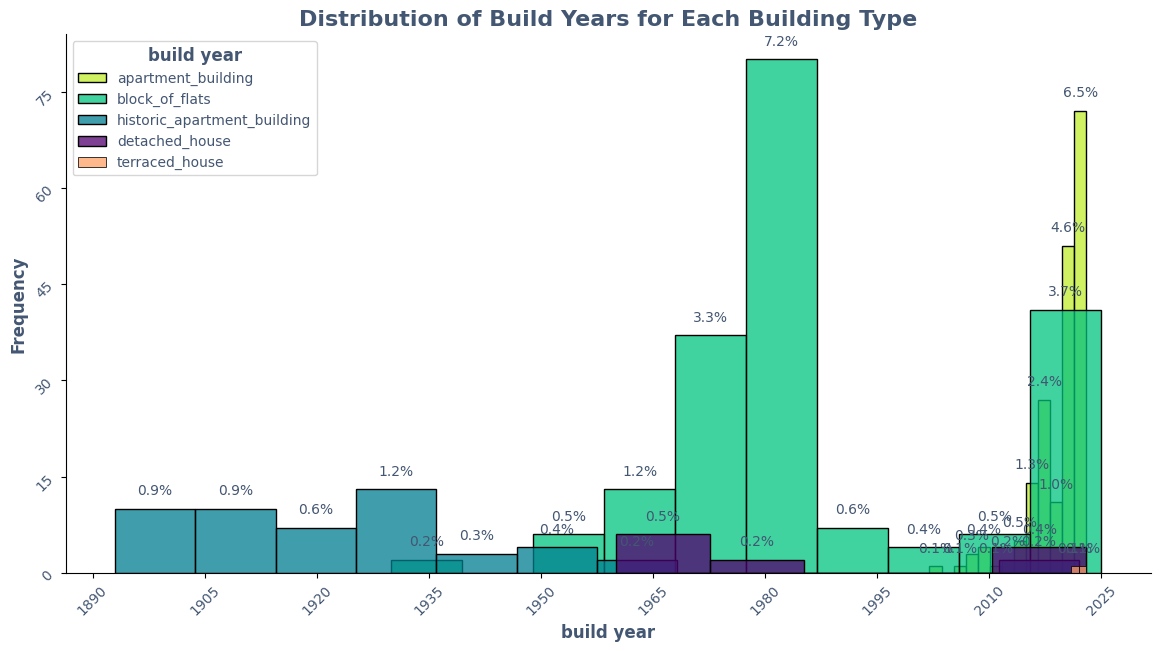

In [34]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('type_and_year', 'building_type'),
    ('type_and_year', 'build_year'),
    'Distribution of Build Years for Each Building Type'
    )

**Insights Building Type and Build Year**:
1. **Block of flats**:<br>
comprising `48.2%` of the dataset, is the predominant category, indicating a strong preference for `apartment` living offers. This choice is common in both `historical urban` areas, and the later era often characterized by "large panel system-building" from communist times, and in newer developments, showing a consistent demand for this type of housing throughout different eras.

1. **Trends in urbanism**:<br>
he notable increase in construction after the year `2000` points to a rise in the availability of newer residences. However, `terraced houses` and `detached houses` make up only `0.3%` and `2.8%` of the housing types, respectively, signifying their rare occurrence in recent urban development. This scarcity suggests an urban development trend that favors multi-story buildings over individual houses, indicating a preference for vertical expansion in housing developments.

In [35]:
def move_index_to_last(series, index_to_move):
    """
    Moves a specified index to the last position in a pandas Series.

    Args:
    series (pd.Series): The original series.
    index_to_move (str): The index to be moved to the last position.

    Returns:
    pd.Series: A new series with the specified index moved to the last position.
    """
    if index_to_move not in series.index:
        raise ValueError(f"Index '{index_to_move}' not found in the Series.")

    # Extracting the indices
    idx_list = series.index.tolist()

    # Remove the index to move and then append it at the end
    idx_list.remove(index_to_move)
    idx_list.append(index_to_move)

    # Reindexing the series
    return series.reindex(idx_list)

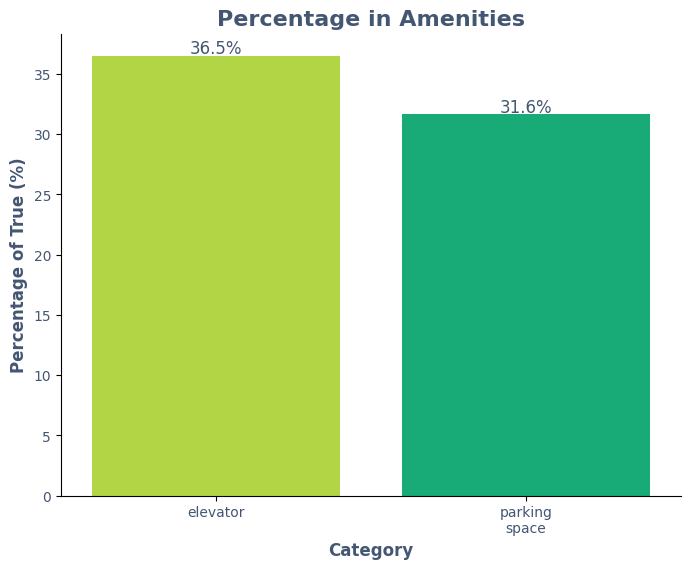

In [36]:
def visualize_true_percentage_by_category(df: pd.DataFrame, main_category: str):
    # Check if the DataFrame contains the main category
    if main_category not in df.columns.get_level_values(0):
        raise KeyError(f"Main category '{main_category}' not found in DataFrame.")

    # Extract subcategories for the given main category
    subcategories = [col for col in df.columns if col[0] == main_category]

    # Calculate percentage of True values for each subcategory
    percentages = {}
    for subcat in subcategories:
        percentages[subcat[1]] = (df[subcat].sum() / len(df)) * 100

    # Convert to Series for plotting
    category_percentage = pd.Series(percentages)

    # Sort by percentage, 'no_information' should be last
    category_percentage = category_percentage.sort_values(ascending=False)
    if 'no_information' in category_percentage.index:
        category_percentage = move_index_to_last(category_percentage, 'no_information')

    # Create a bar plot
    if category_percentage.index.__len__() >= 5:
        plot_size = aesthetics_plots["figsize"]["multiplot"]
    else:
        plot_size = aesthetics_plots["figsize"]["singleplot"]

    fig, ax = plt.subplots(figsize=plot_size)

    # Set the palette
    length = len(category_percentage.index)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    if 'no_information' in category_percentage.index:
        my_palette = my_palette[:max(1, length - 1)] + ['#b3b3b3']

    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', '\n'))

    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    title = "Percentage in " + main_category.replace('_', ' ').title()
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Category', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Percentage of True (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()

visualize_true_percentage_by_category(combined_df, 'amenities')

**Insights Amenities**:
1. **Elevators**:<br>
are included in `36.5%` of the apartment offers.
1. **Parking spaces**<br>
are available in `31.6%` of the listings.

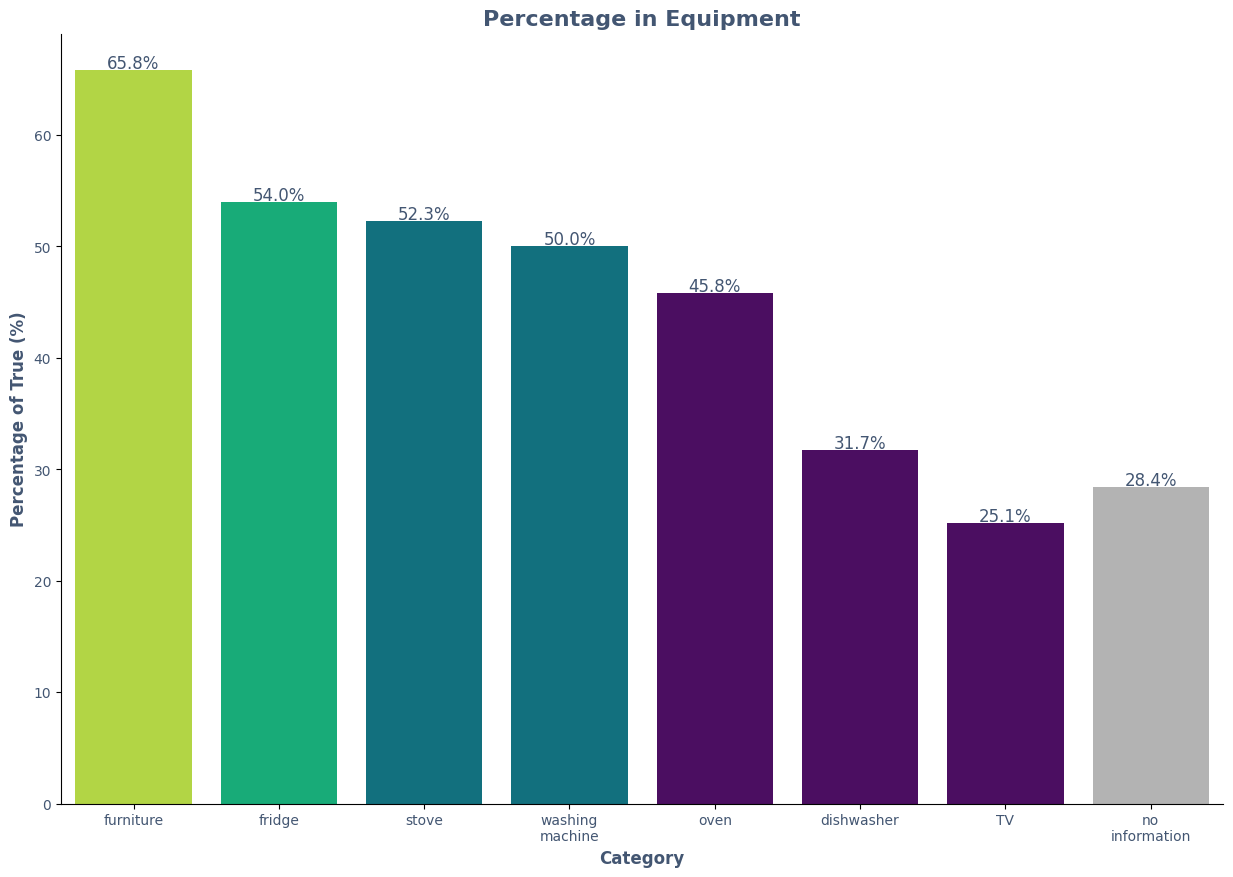

In [37]:
visualize_true_percentage_by_category(combined_df, 'equipment')

**Insights Equipment**:

1. **Trends in home furnishings**:<br>
`Furniture` is included in `65.8%` of the apartments, while `fridges` and `stoves` are present in `54%` and `52.3%` of the units, respectively, and `washing machines` are found in exactly `half` of the offerings. This demonstrates a tendency for apartments to be equipped with essential appliances for tenants seeking ready-to-move-in properties.
1. **Rarer amenities**:<br>
The presence of `TVs` in `25.1%` and `dishwashers` in `31.7%` of the offers shows these are less common, possibly due to being considered non-essential.

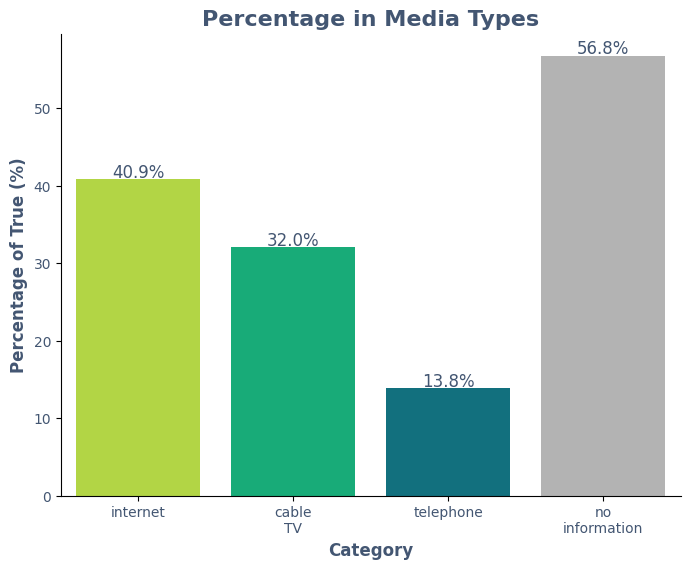

In [38]:
visualize_true_percentage_by_category(combined_df, 'media_types')

**Insights Media Types**:
1. **Universality**:<br>
`Internet access` is mentioned in `40.9%` of the listings and, `32.0%` for the `cable tv`.
1. **No information**:<br>
about media types is reported in `56.8%` of the offers, showing that for most it's irrelevant information.

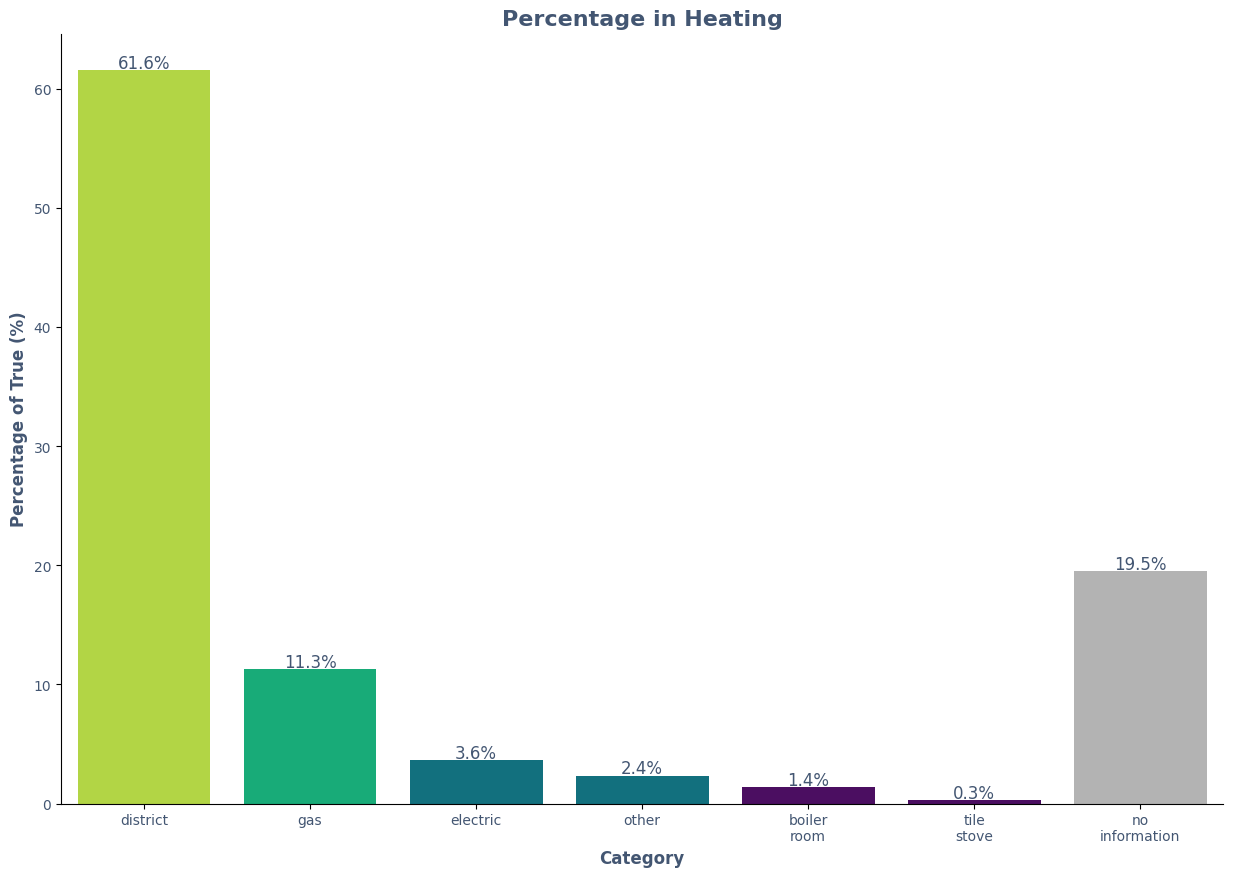

In [39]:
visualize_true_percentage_by_category(combined_df, 'heating')

**Insights Heating**:

1. **District heating**:<br>
is the most reported type at `61.6%`, reflecting its widespread use in urban settings or apartment complexes.
1. **Othe heating**:<br>
The `gas` `11.3%` and especially `electric` `3.6%` heating is low due to high costs.

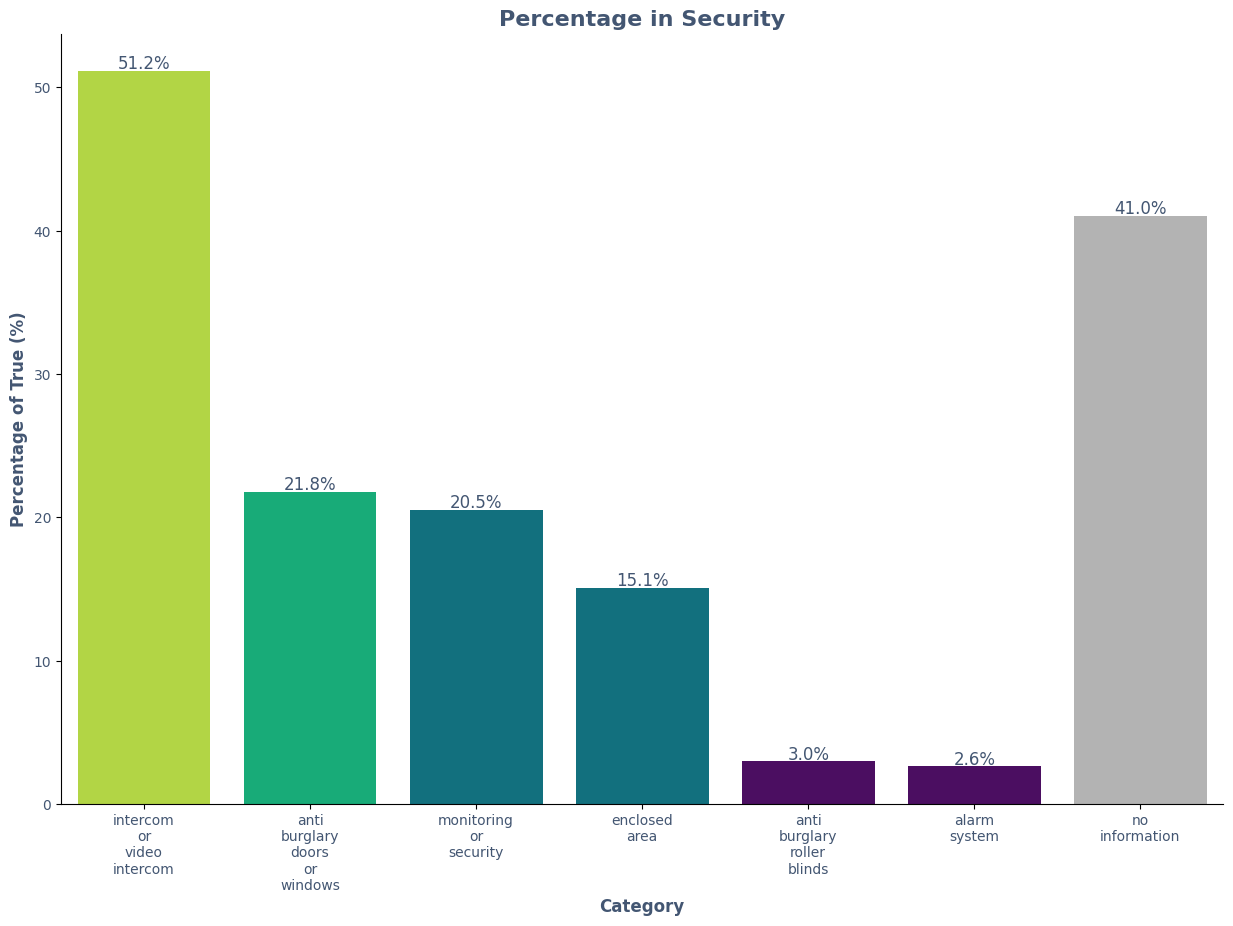

In [40]:
visualize_true_percentage_by_category(combined_df, 'security')

**Insights Security**:

1. **Intercom Systems**:<br>
`Intercom` or `video intercom` systems are noted in `51.2%` of the offers, quite common feature.
1. **More advanced security features**:<br>
like `alarm systems` are mentioned in only `2.6%` of the listings, and `anti-burglary roller blinds` in `3.0%`, suggesting that these may be less common or highlighted only in premium offerings.

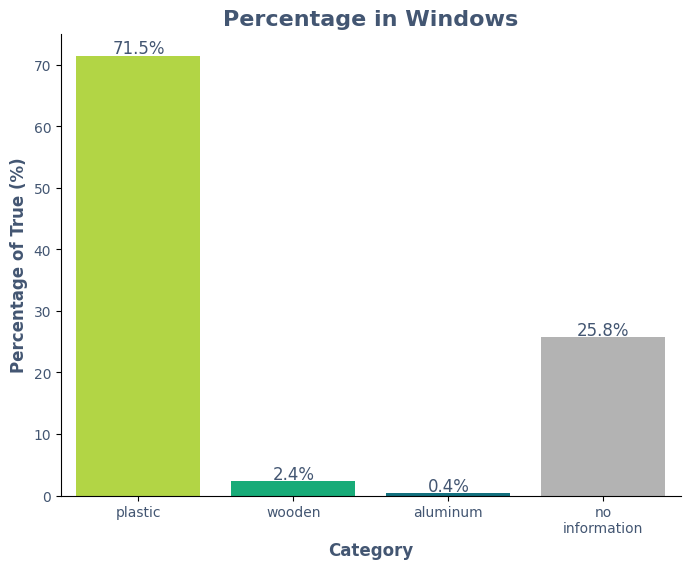

In [41]:
visualize_true_percentage_by_category(combined_df, 'windows')

**Insights Windows**:

1. **Plastic**:<br>
windows dominate the features at `71.5%`.
1. **No information**:<br>
There is a notable `lack of information` in `25.8%` of listings regarding window types.

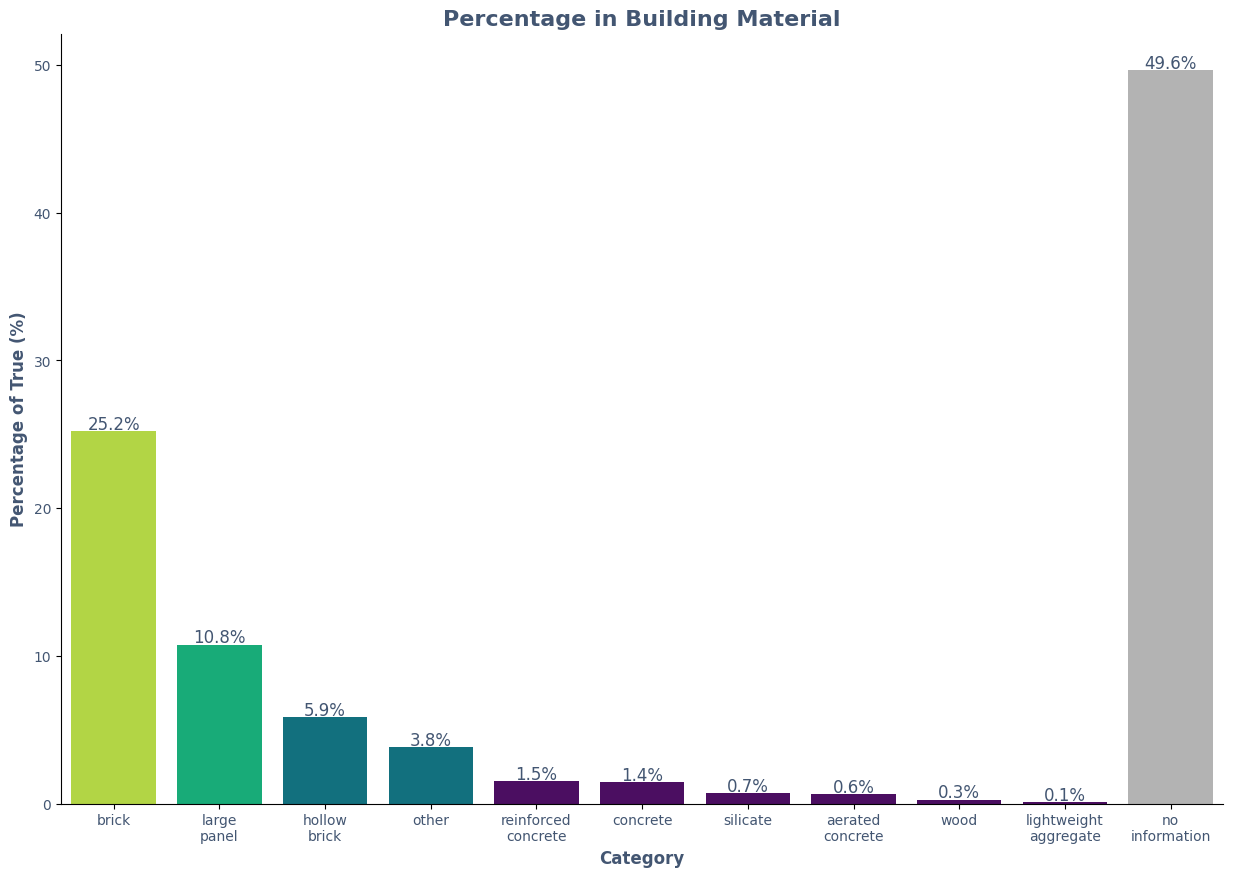

In [42]:
visualize_true_percentage_by_category(combined_df, 'building_material')

**Insights Building Material**:

1. **Brick**:<br>
is specified in `25.2%` of the properties, possibly due to its desirable qualities such as durability and insulation.
1. **Large panel**:<br>
is mentioned in `10.8%`, but the result could be undermined by not mentioning it due to unpopularity among prospective tenants.
1. **No information**:<br>
Almost half of the listings, at `49.6%`, do `not disclose` building material.

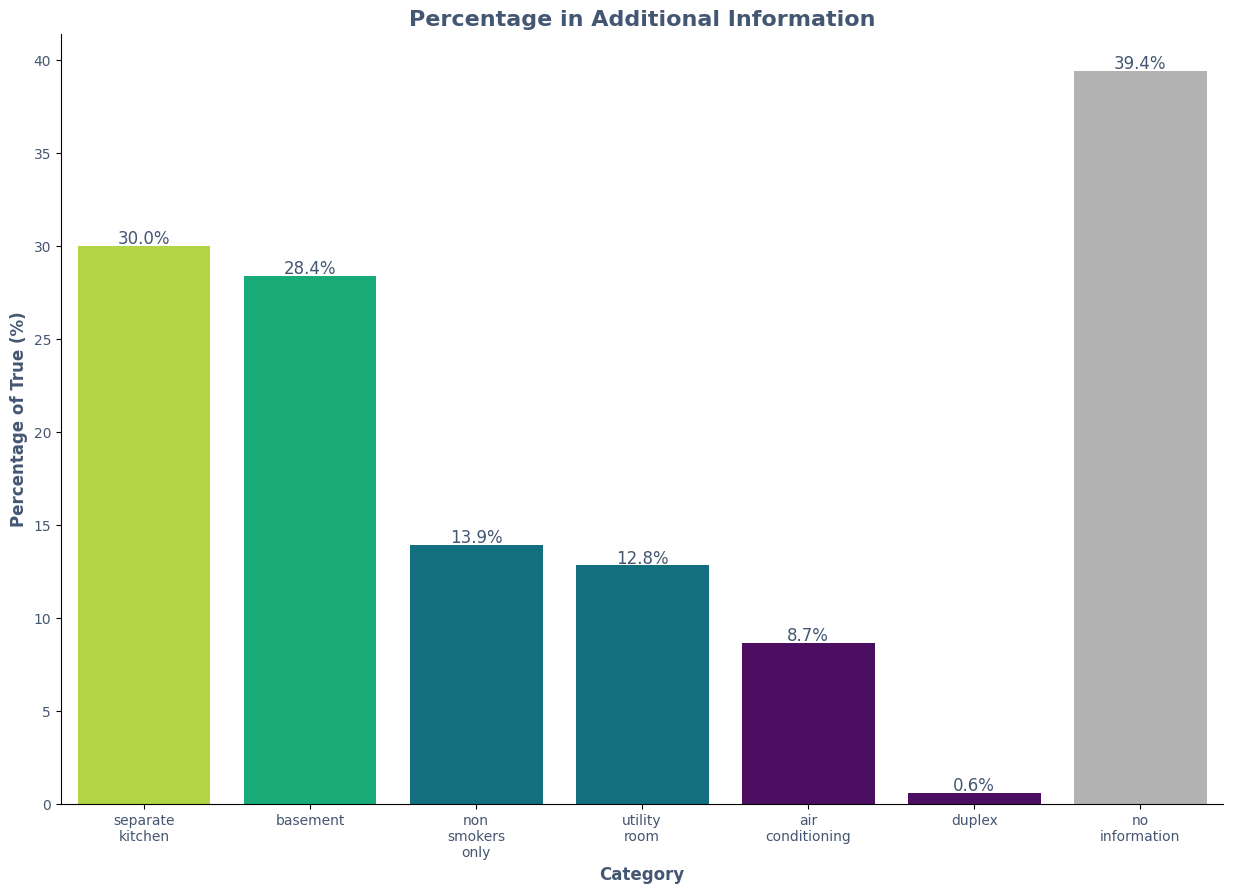

In [43]:
visualize_true_percentage_by_category(combined_df, 'additional_information')

**Additional Information Plot Insights**:
1. `Separate kitchens` and `basements` are prominent features in the apartment offerings, with `30.0%` and `28.4%` of listings advertising these `amenities`, respectively. A clearly defined cooking spaces and additional storage or living areas represented by basements.

1. A smaller but notable percentage of listings specify `non-smokers only` `(13.9%)` and include a `utility room` `(12.8%)`.

1. `Air conditioning` and `duplex configurations` are rare, at `8.7%` and `0.6%` respectively, which may imply that these features are non-standard. The overwhelming of listings `(39.4%)` `do not provide additional information`.